# General Imports

In [132]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import re
import math
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Polygon, Patch
import matplotlib.image as mpimg
from matplotlib.ticker import ScalarFormatter
import matplotlib.dates as mdates

# Colors and Text Size

In [133]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

color = tableau20

plt.rcParams.update({'font.size': 26})

# Importing Data

In [134]:
# allFiles = glob.glob(os.path.join("..","interpolatedData","*","*.csv"))

# df = {}
# for x in allFiles:
#     name = '_'.join(x.split(os.path.sep)[1:]).split('.')[0]
#     df[name] = pd.read_csv(x,parse_dates=[0])
mergedDataFilesDp03 = glob.glob(os.path.join("..","..","mergedData","Dp03","*.csv"))
mergedDataDp03 = {(route.split("Data_")[1].split(".")[0]):pd.read_csv(route,parse_dates=[0]) for route in mergedDataFilesDp03}
mergedDataFilesPM25 = glob.glob(os.path.join("..","..","mergedData","PM25_Std","*.csv"))
mergedDataPM25 = {(route.split("Data_")[1].split(".")[0]):pd.read_csv(route,parse_dates=[0]) for route in mergedDataFilesPM25}

# Graphing all sensor data for Dp>0.3 and PM2.5

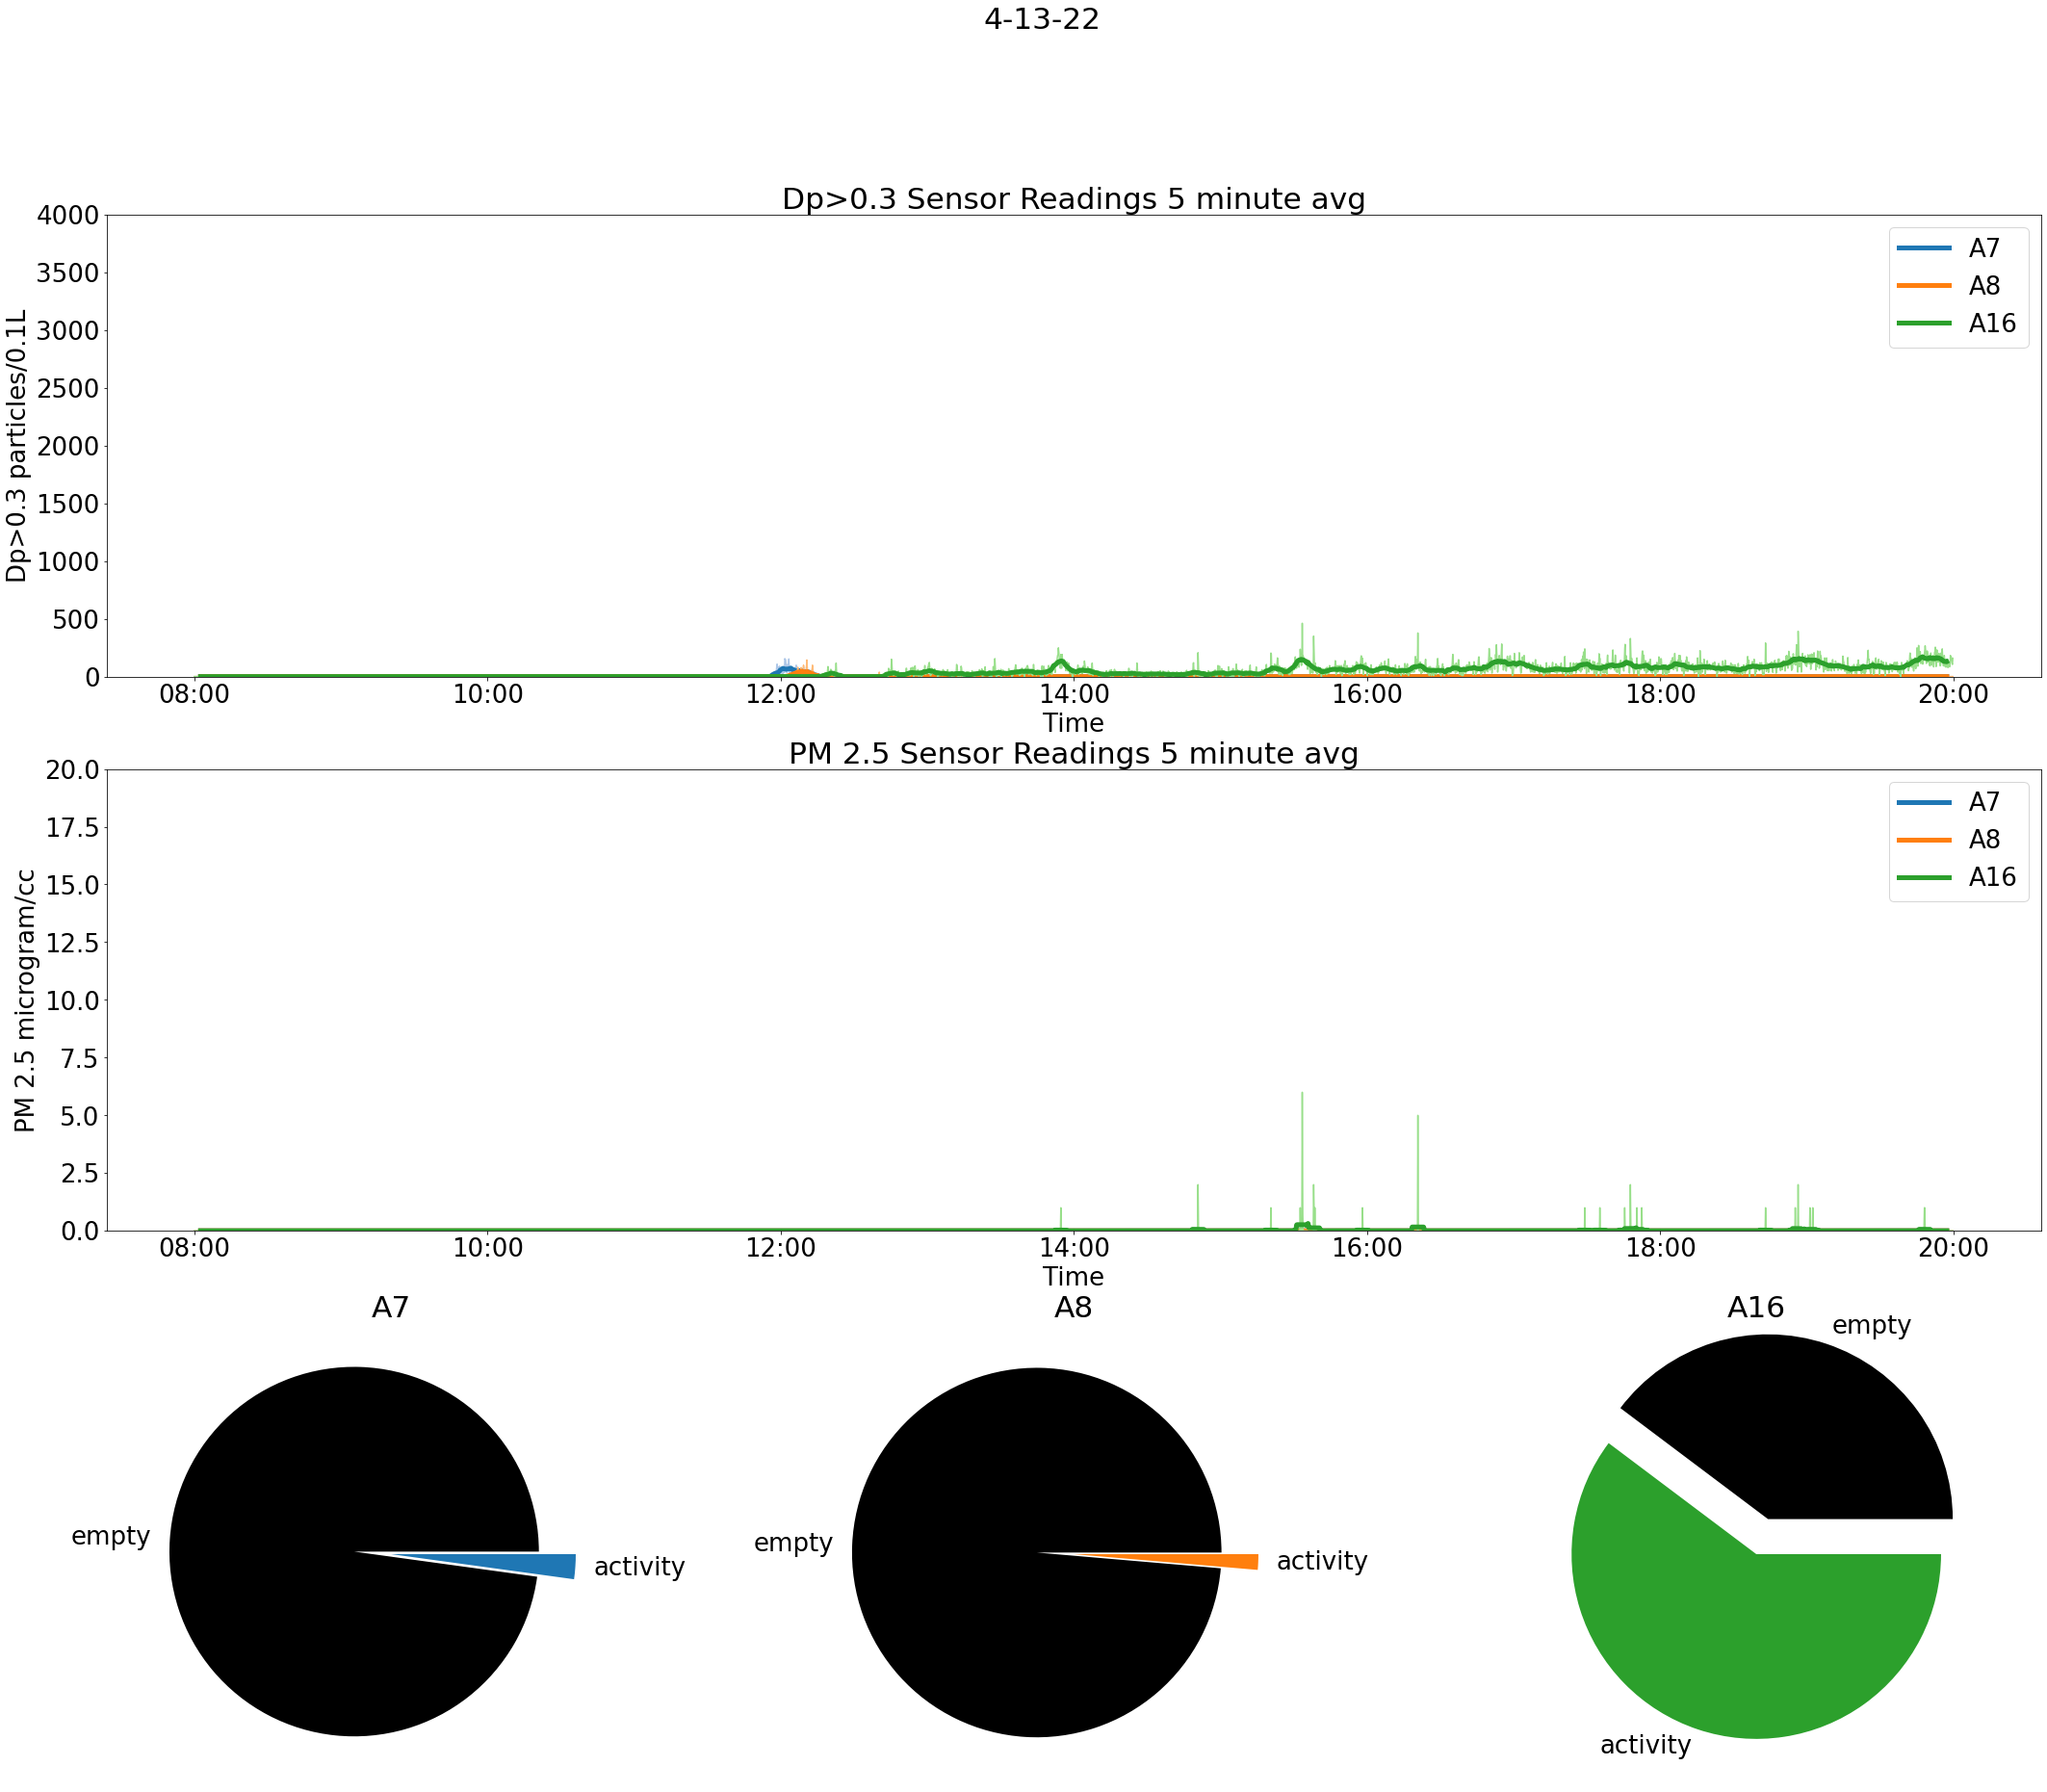

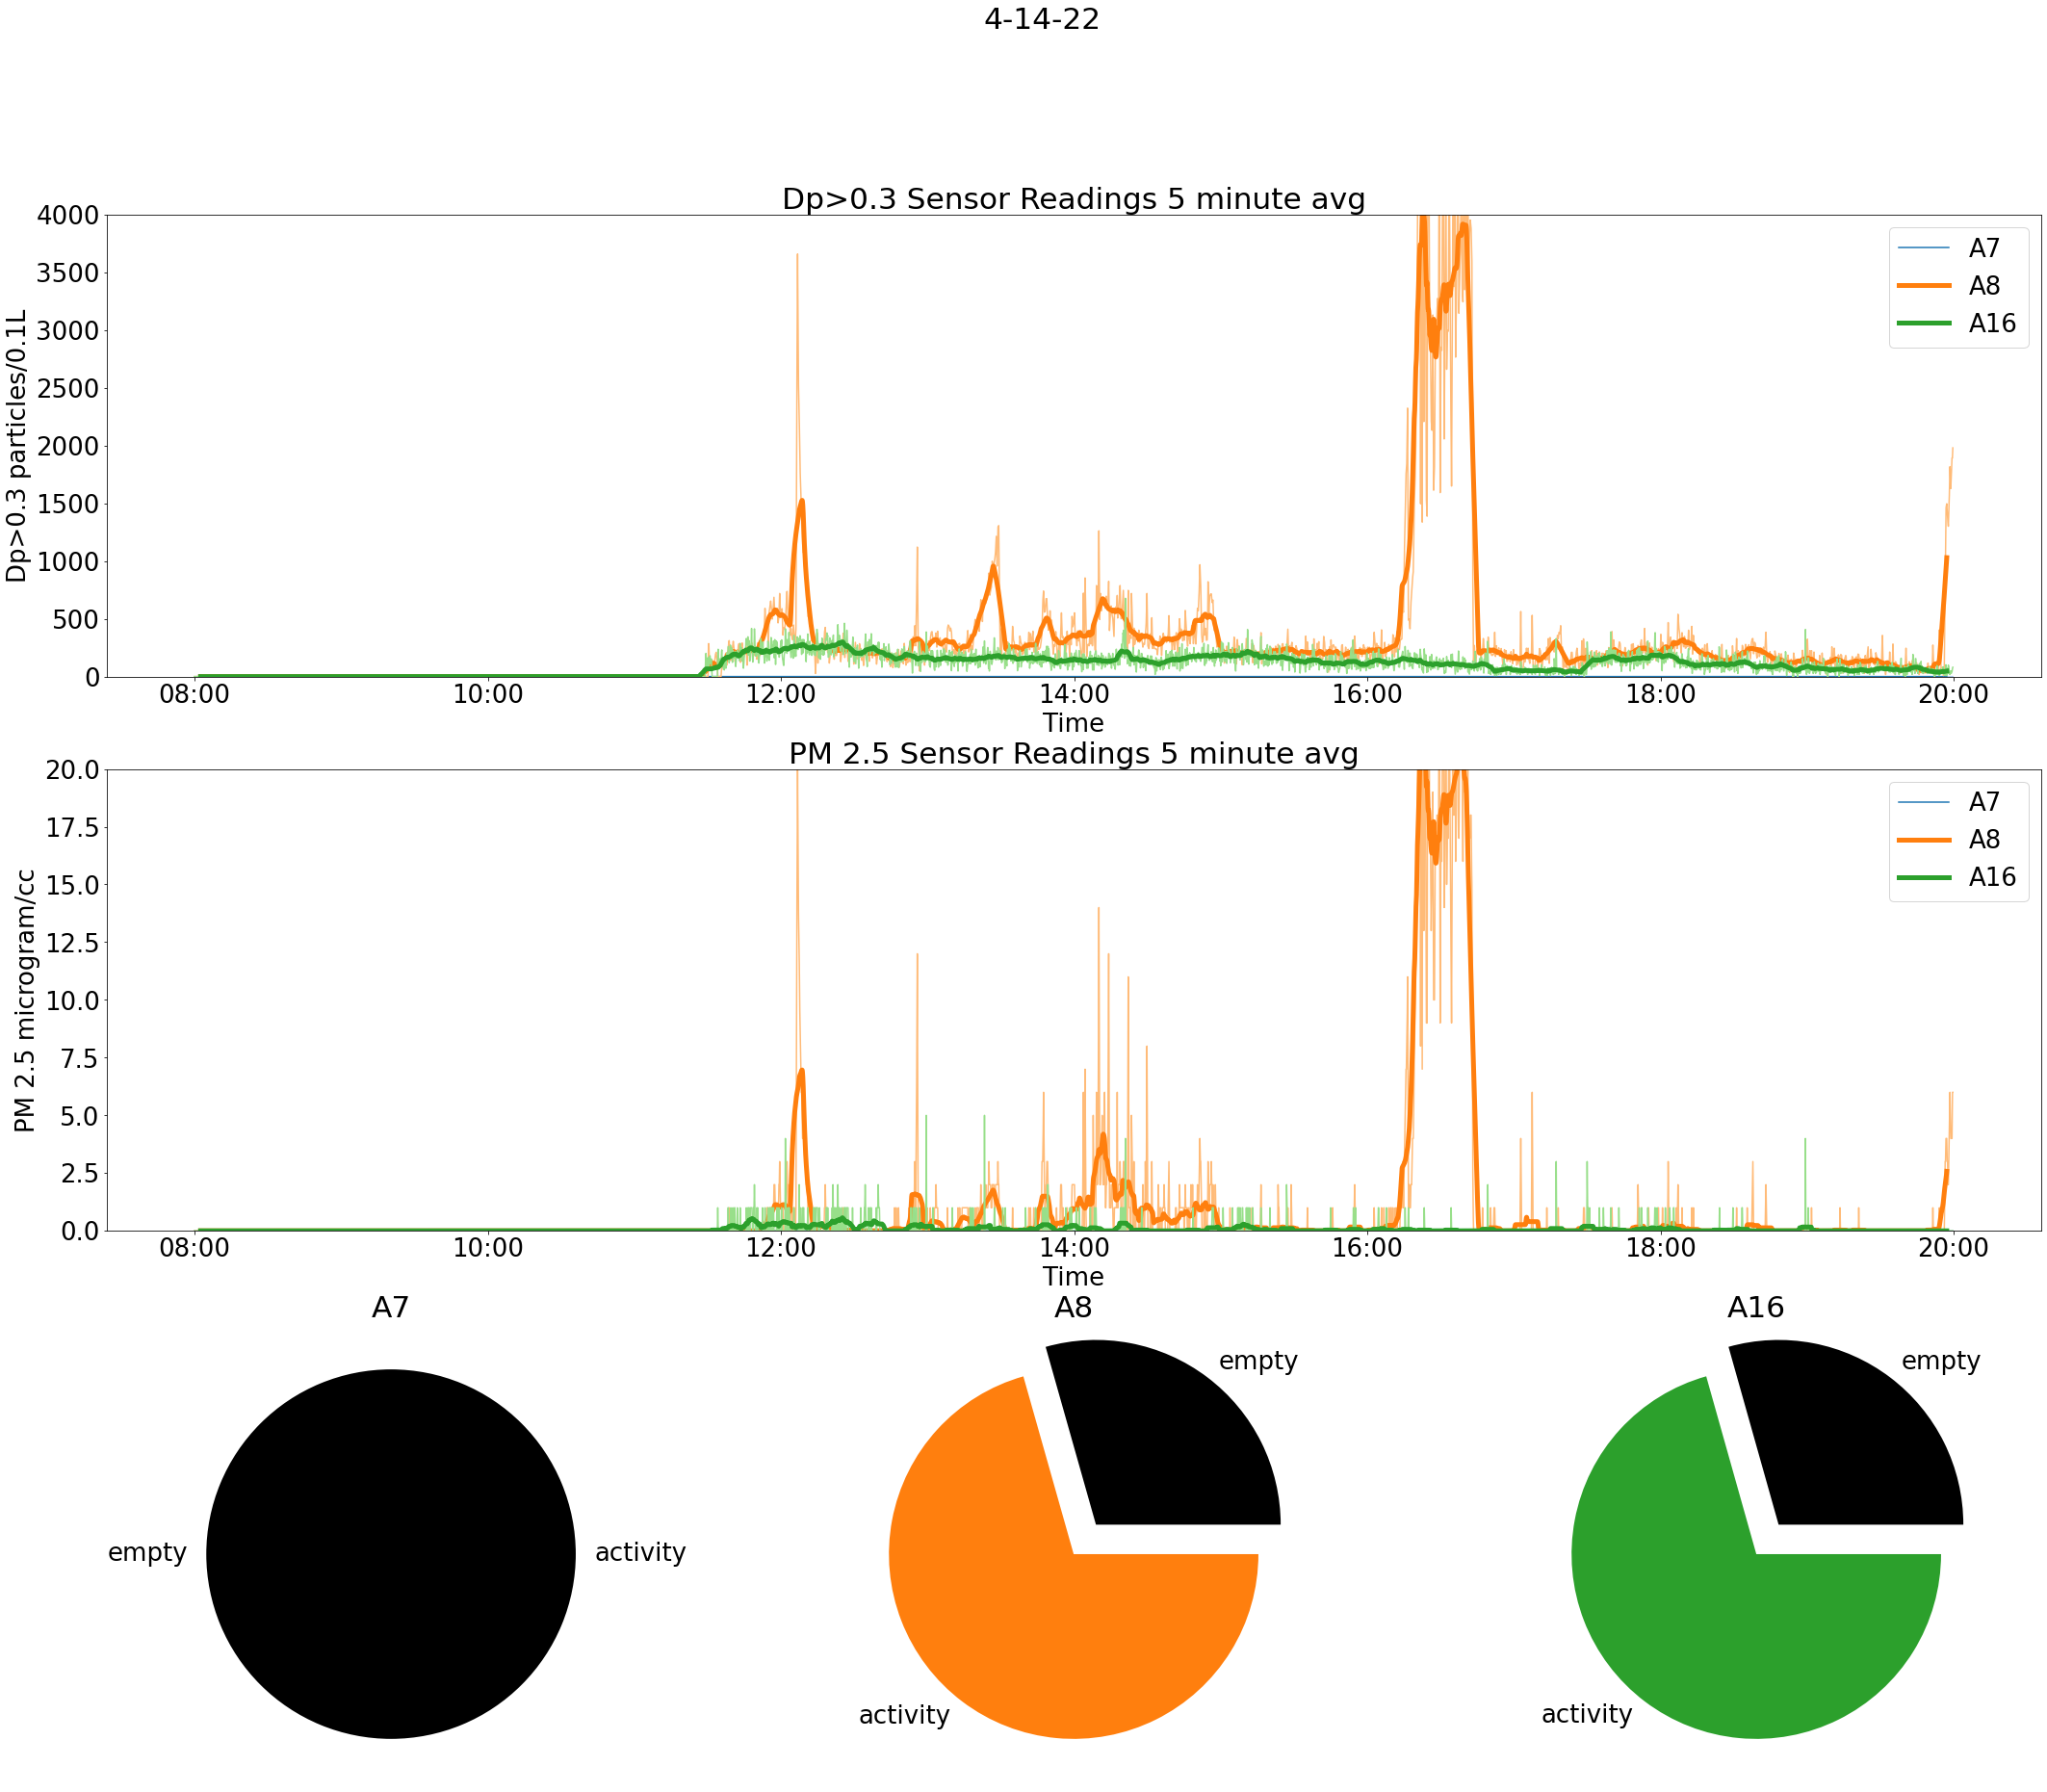

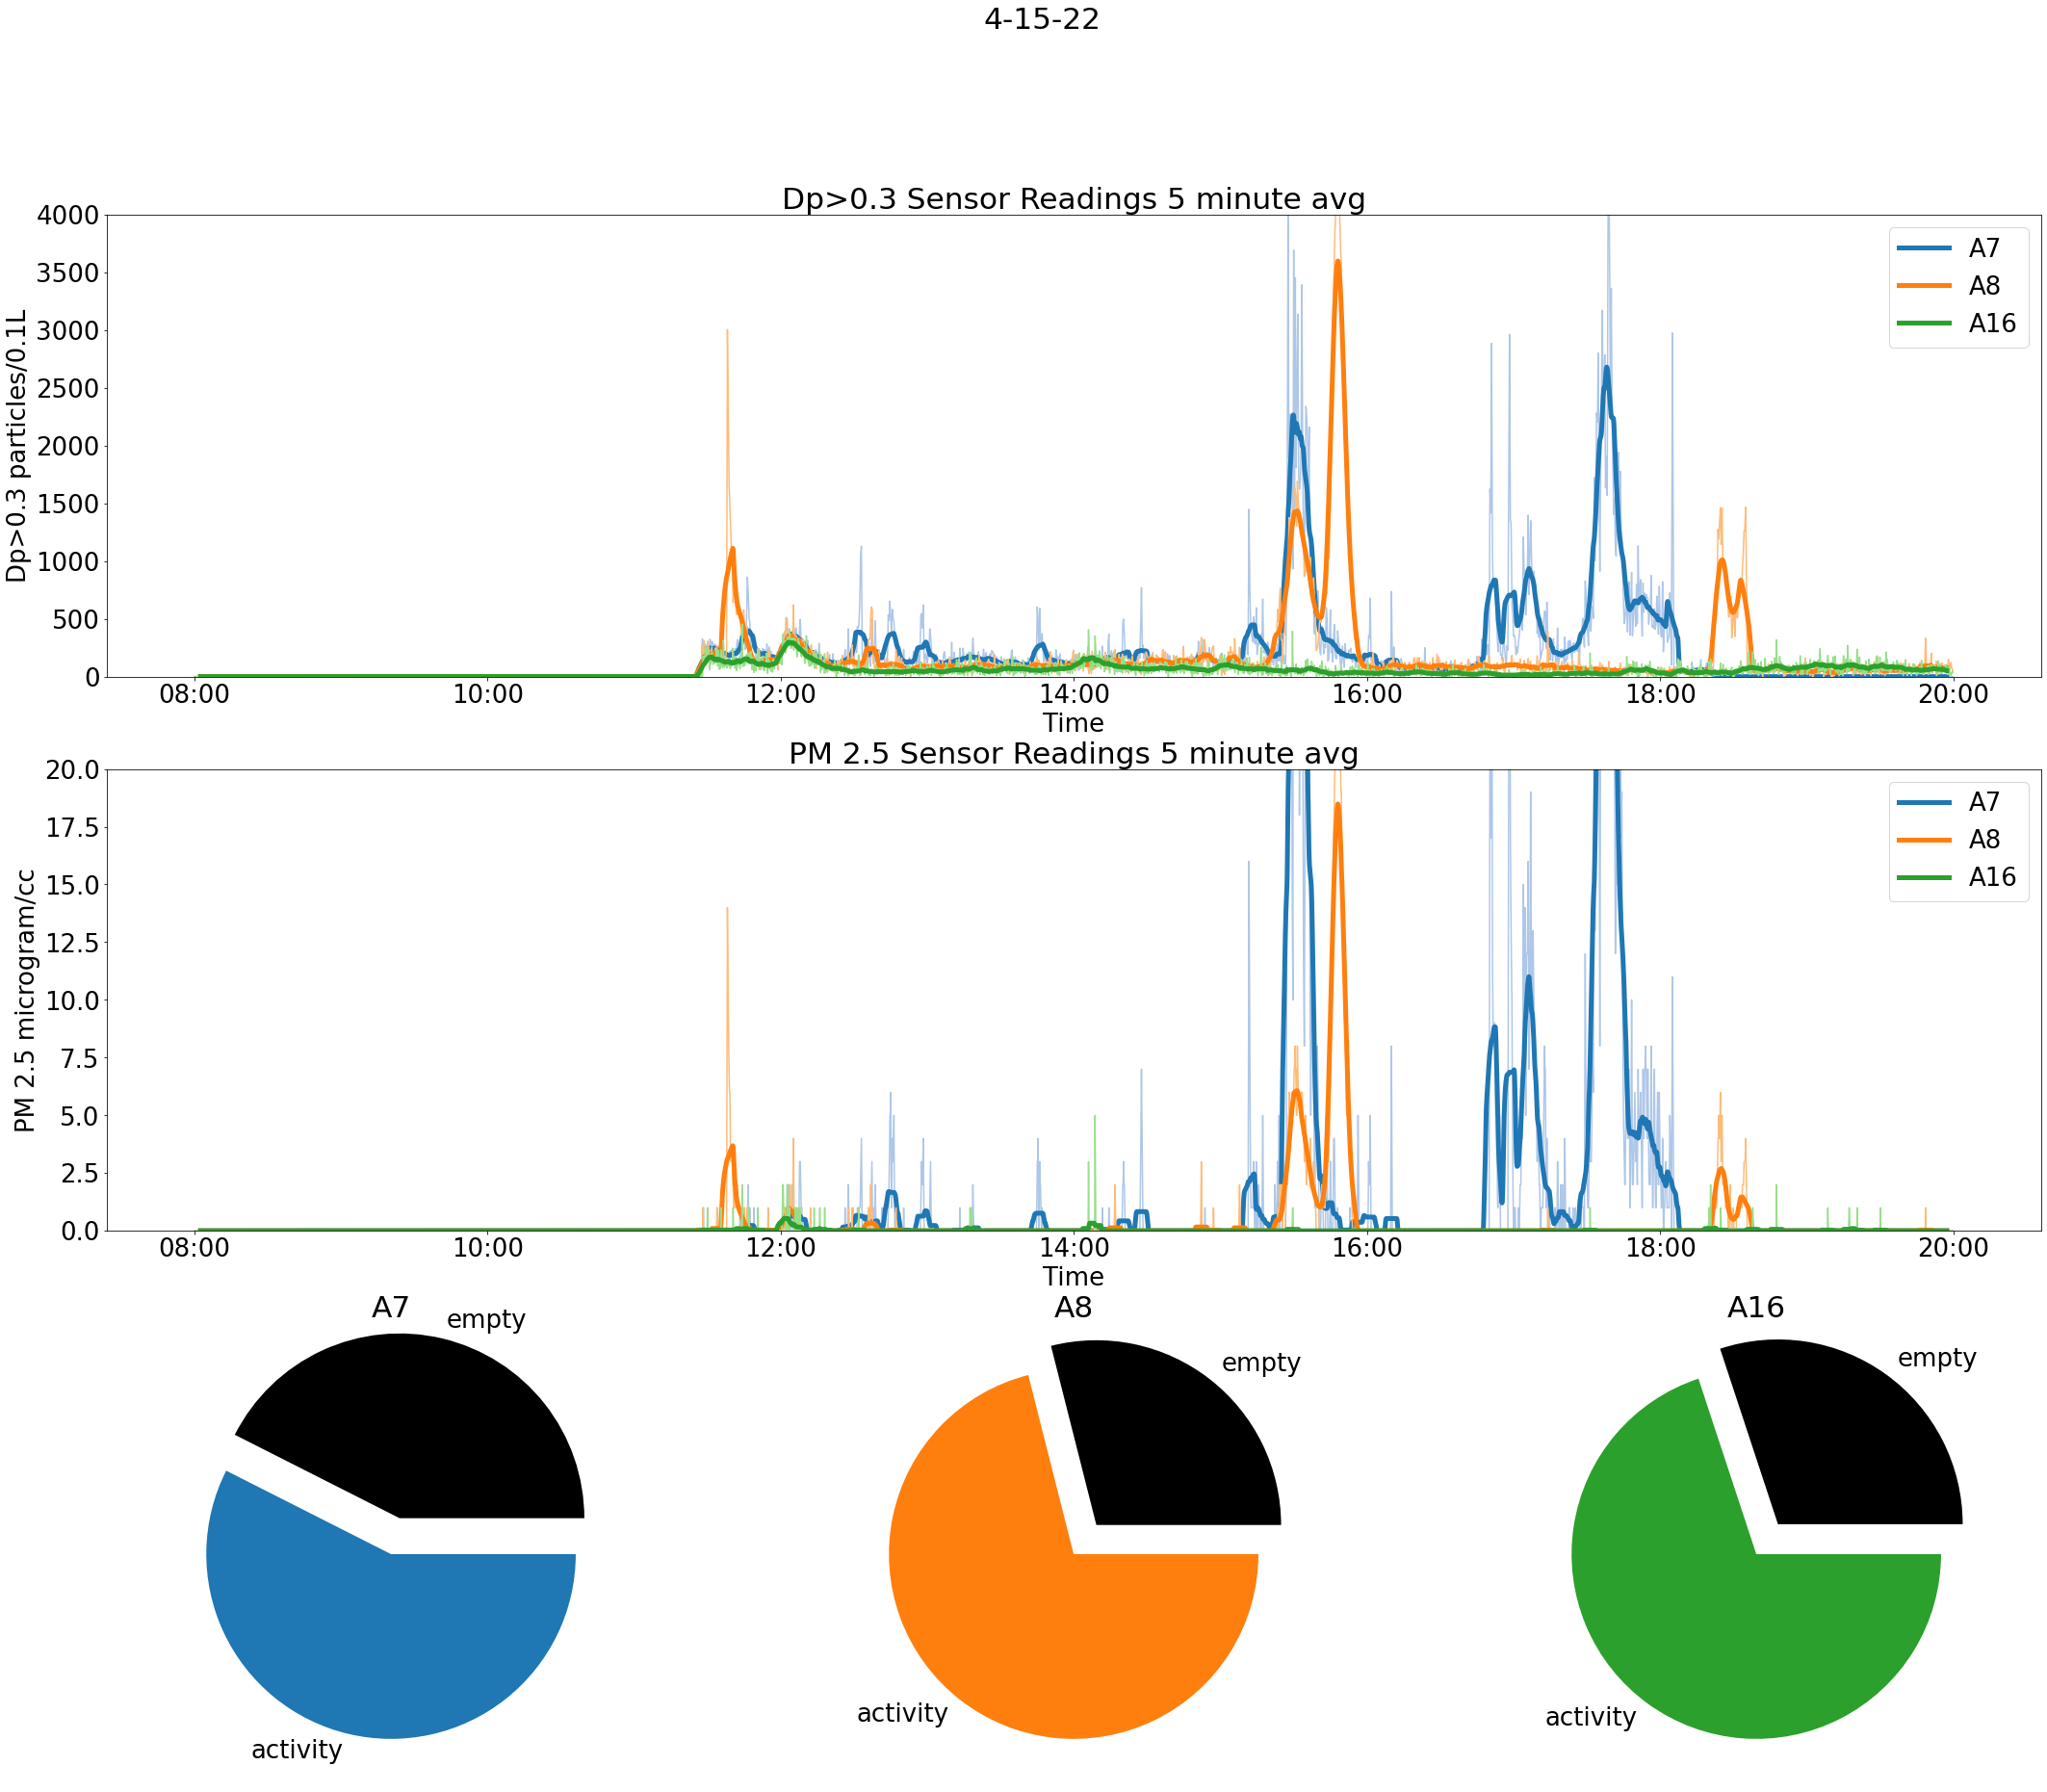

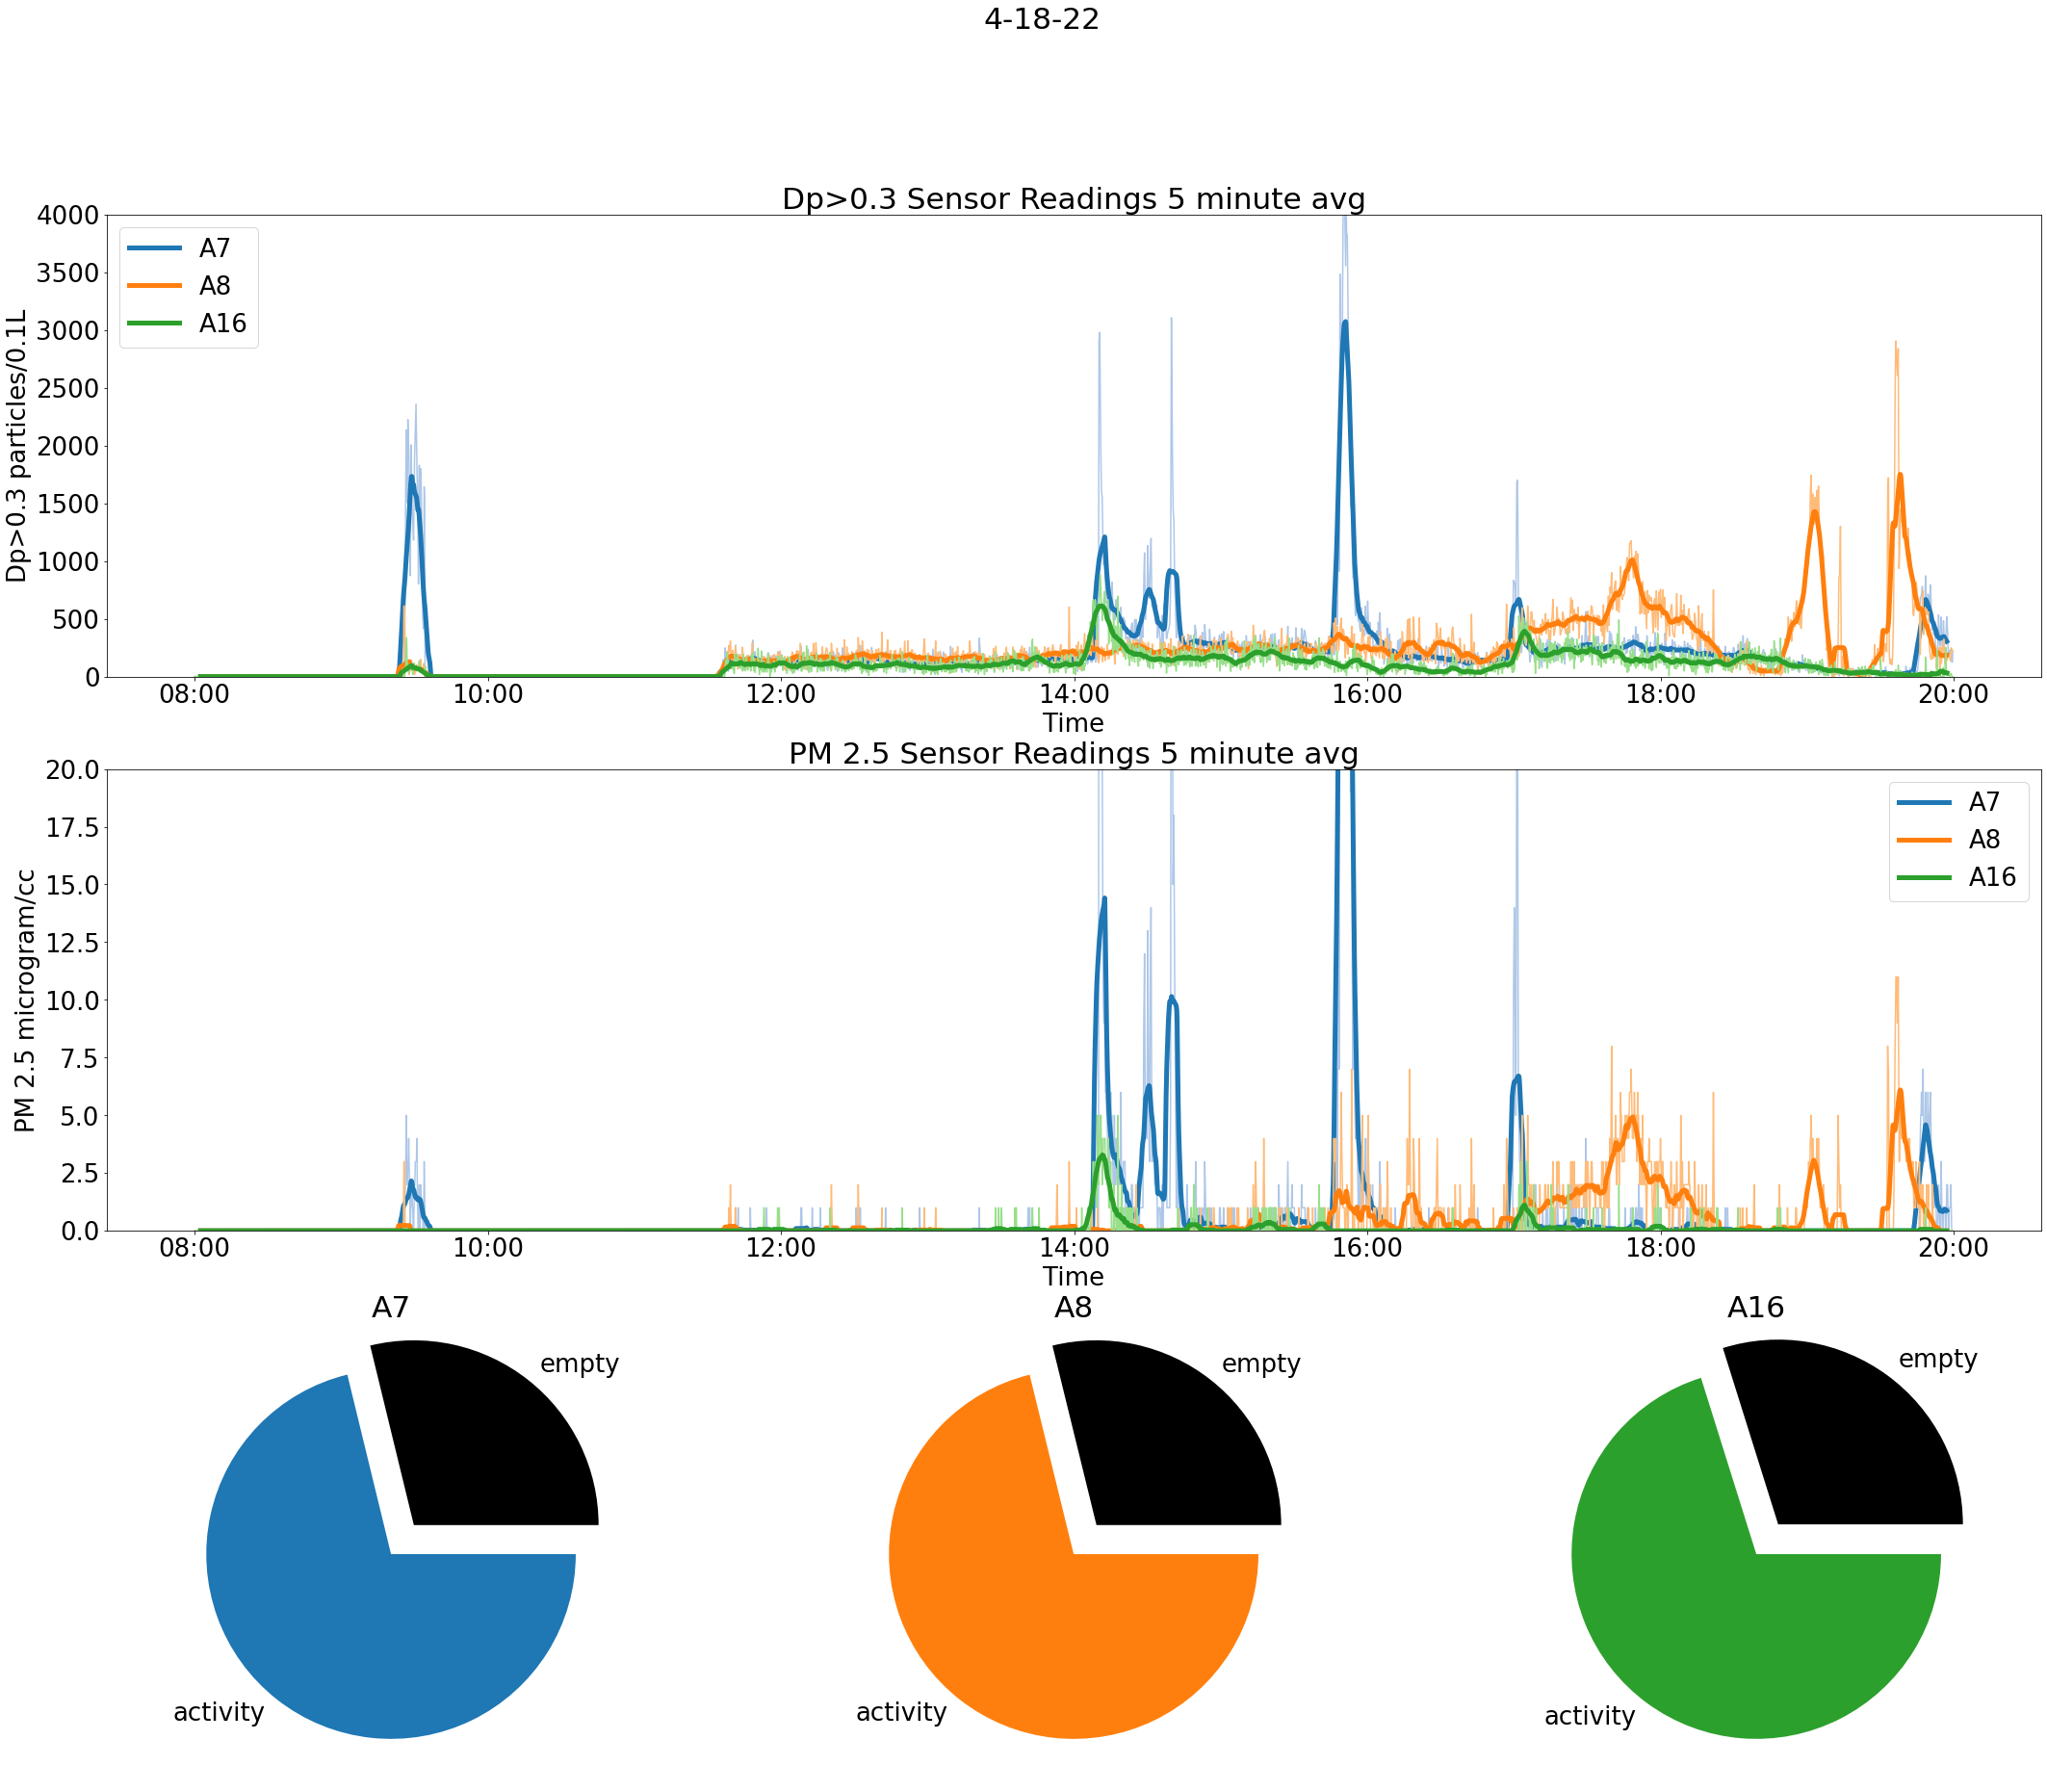

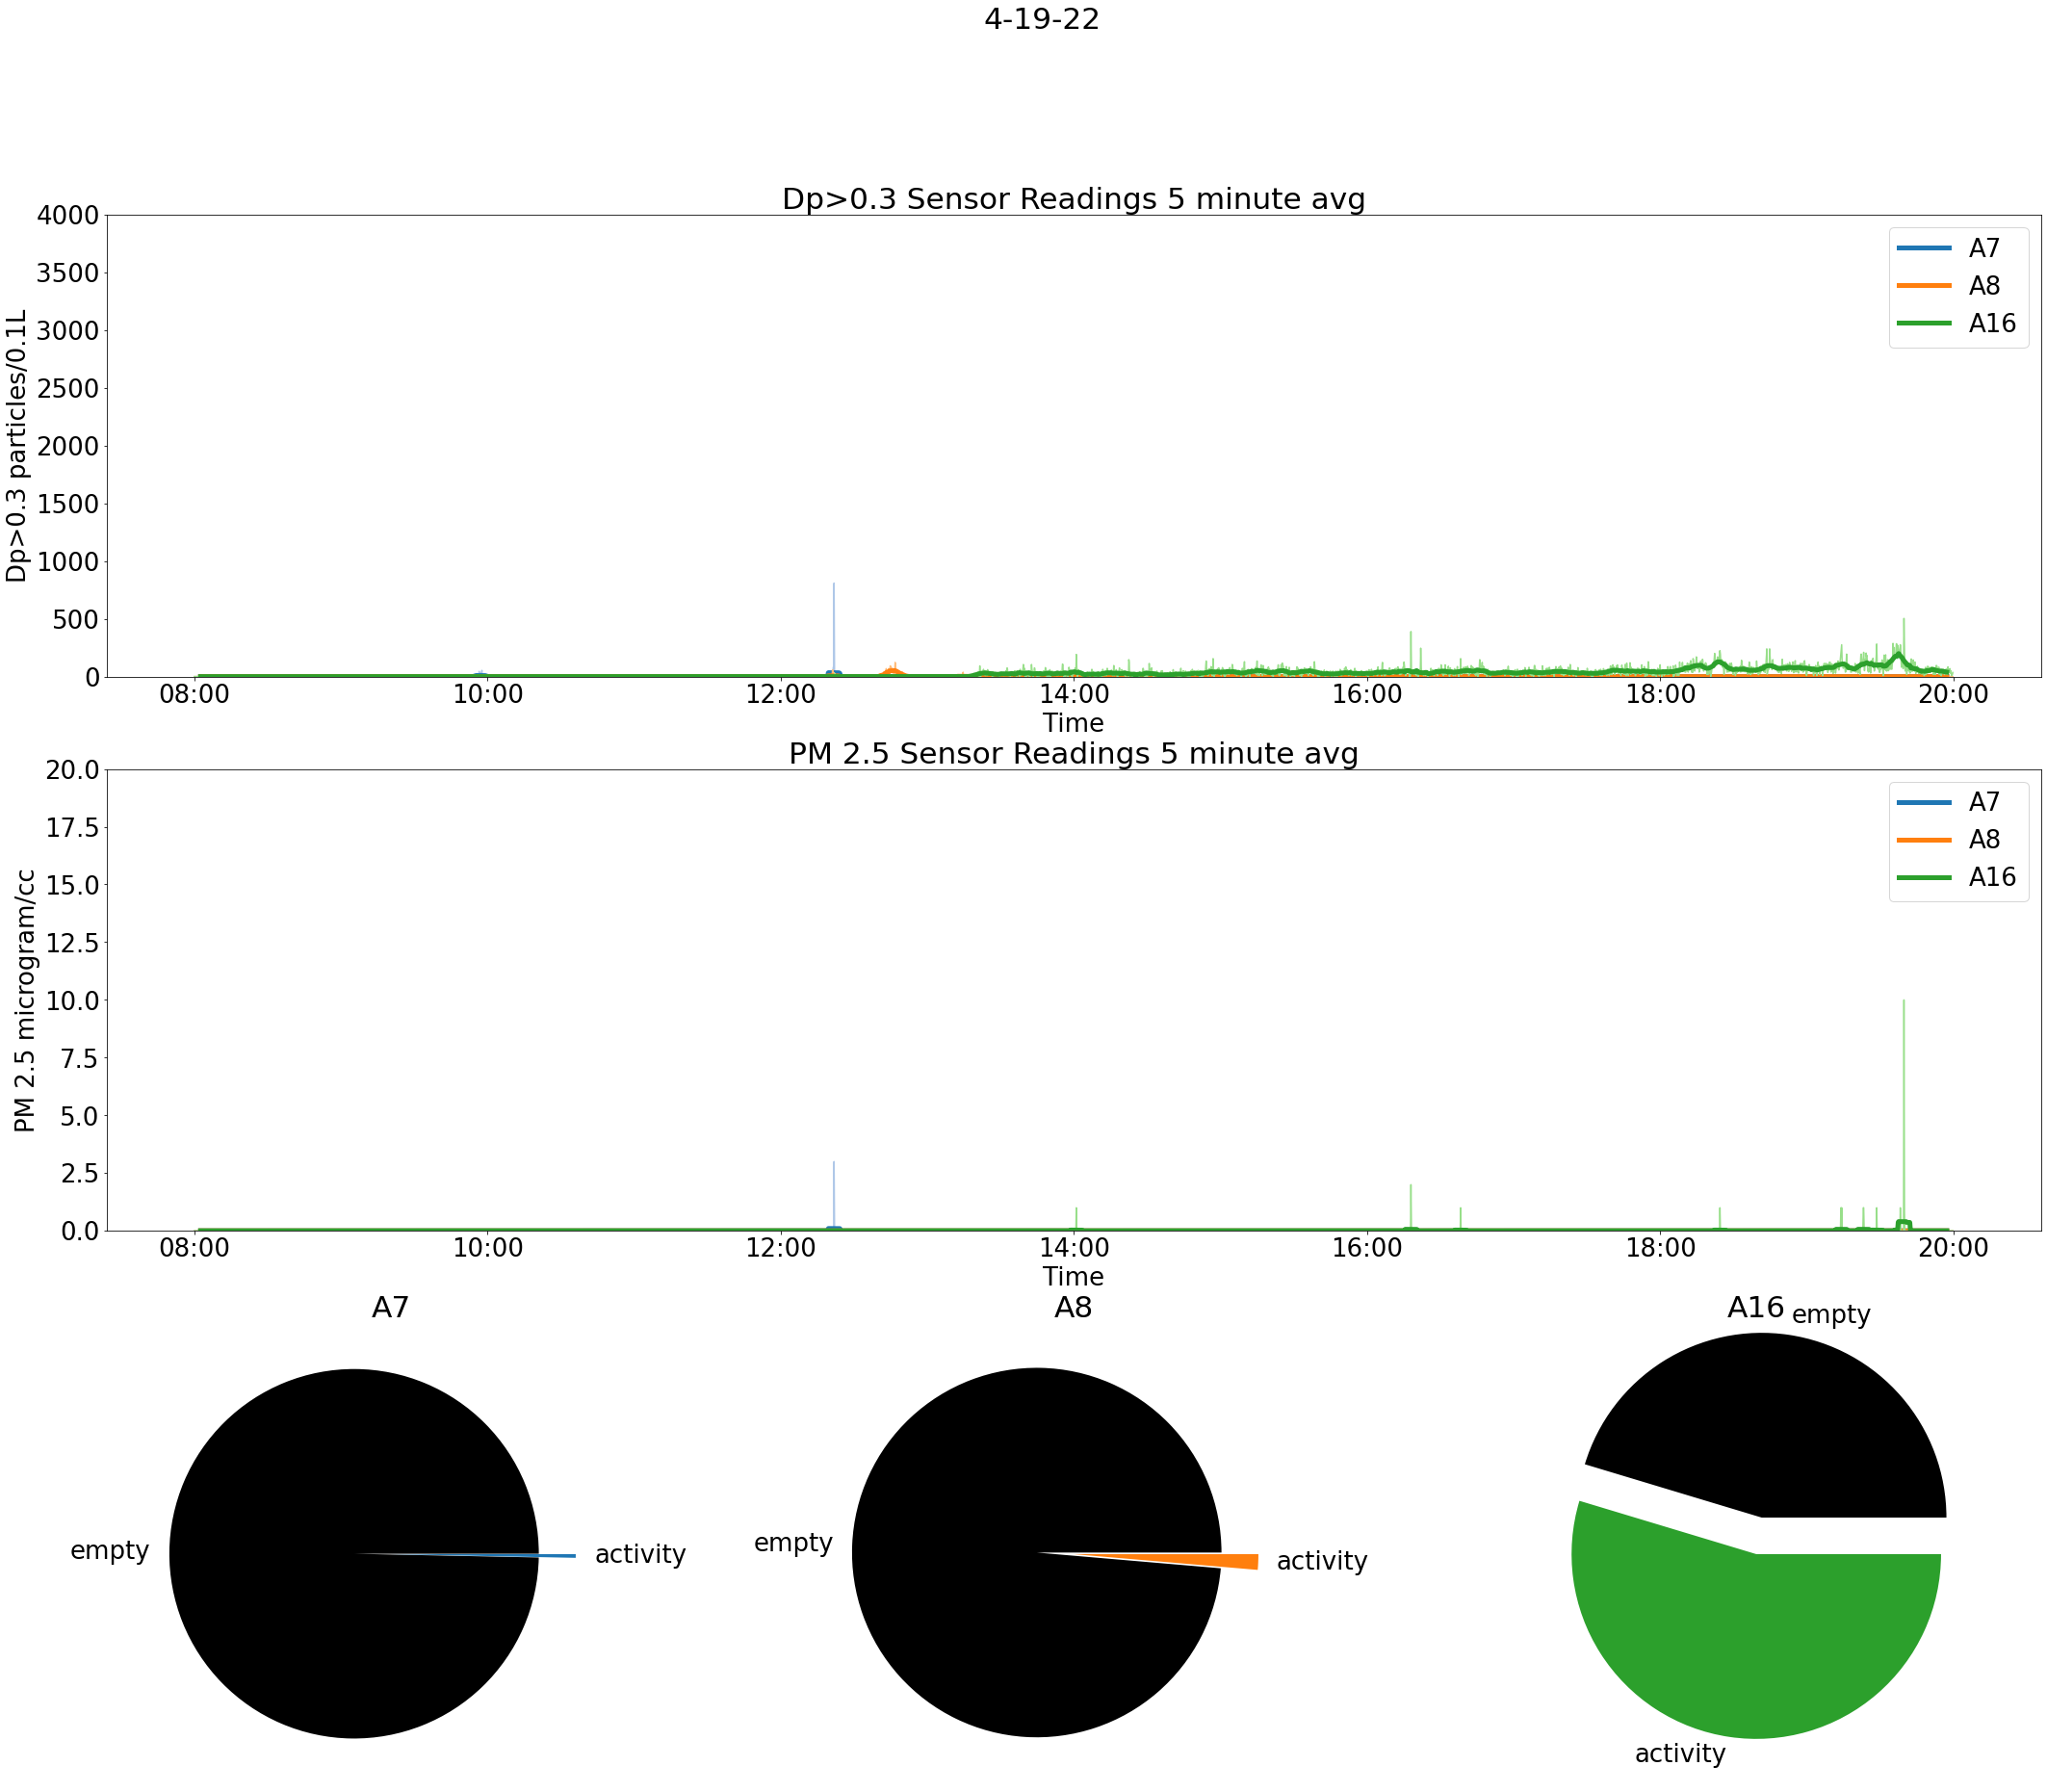

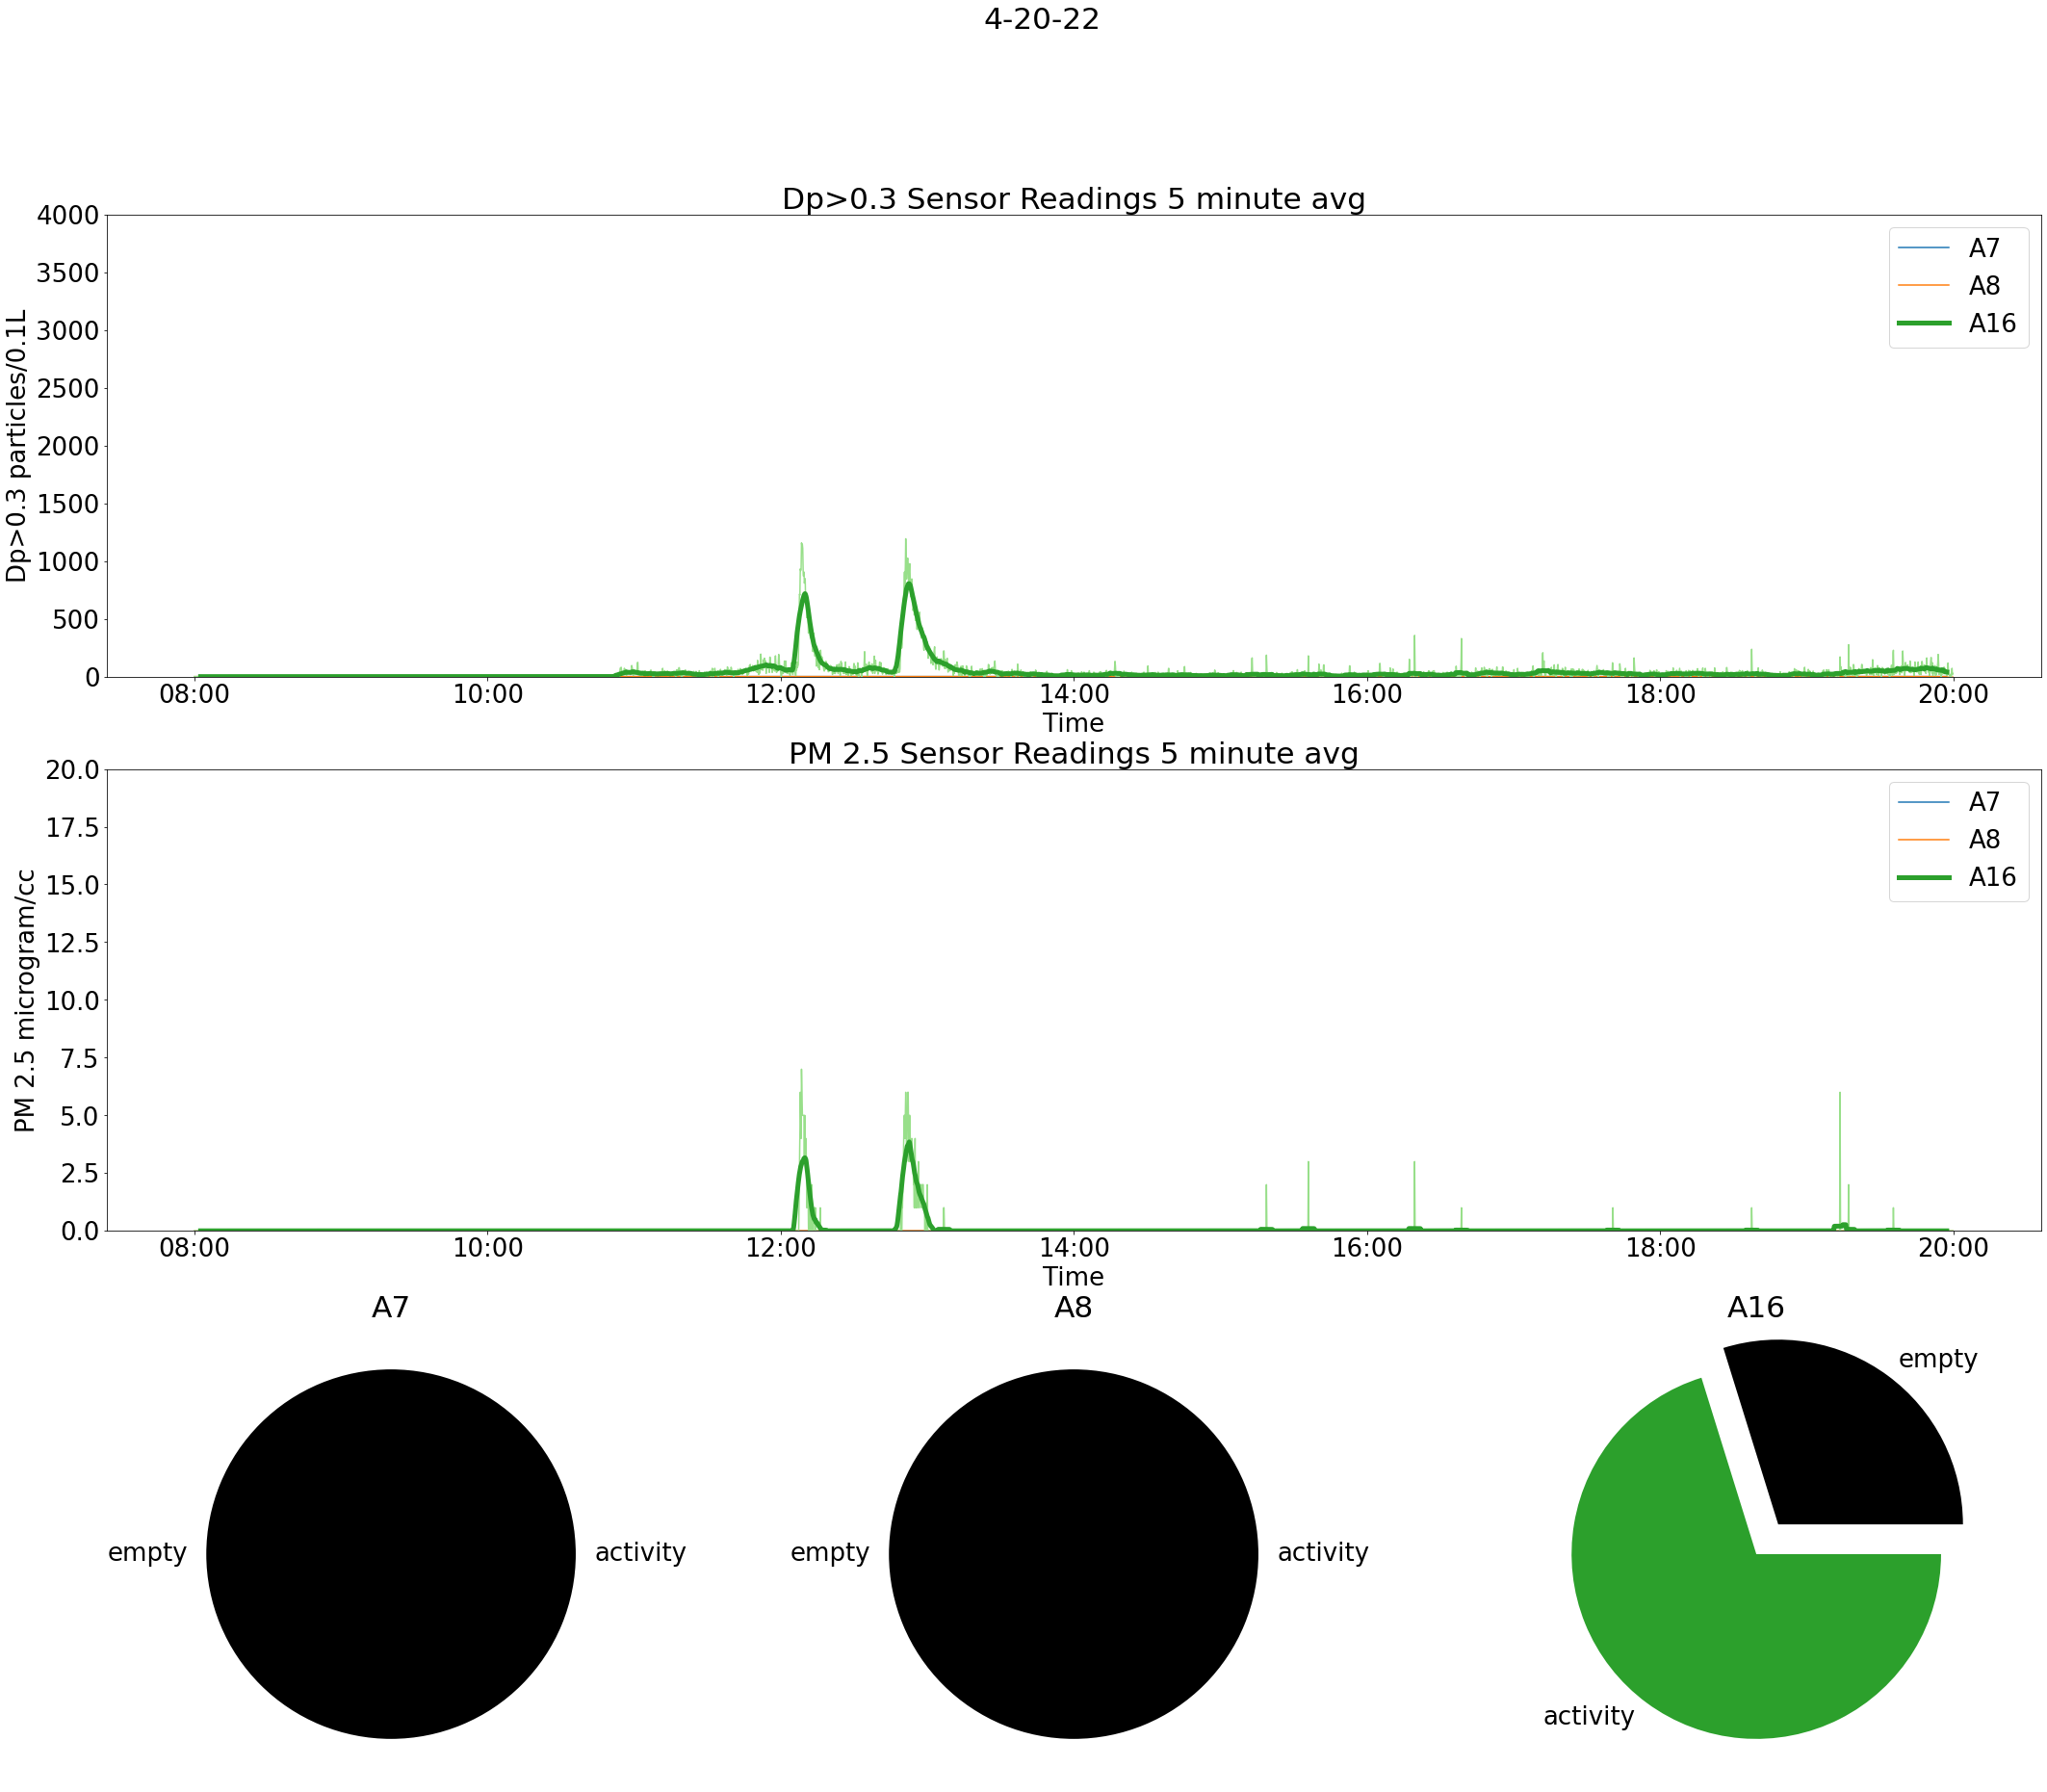

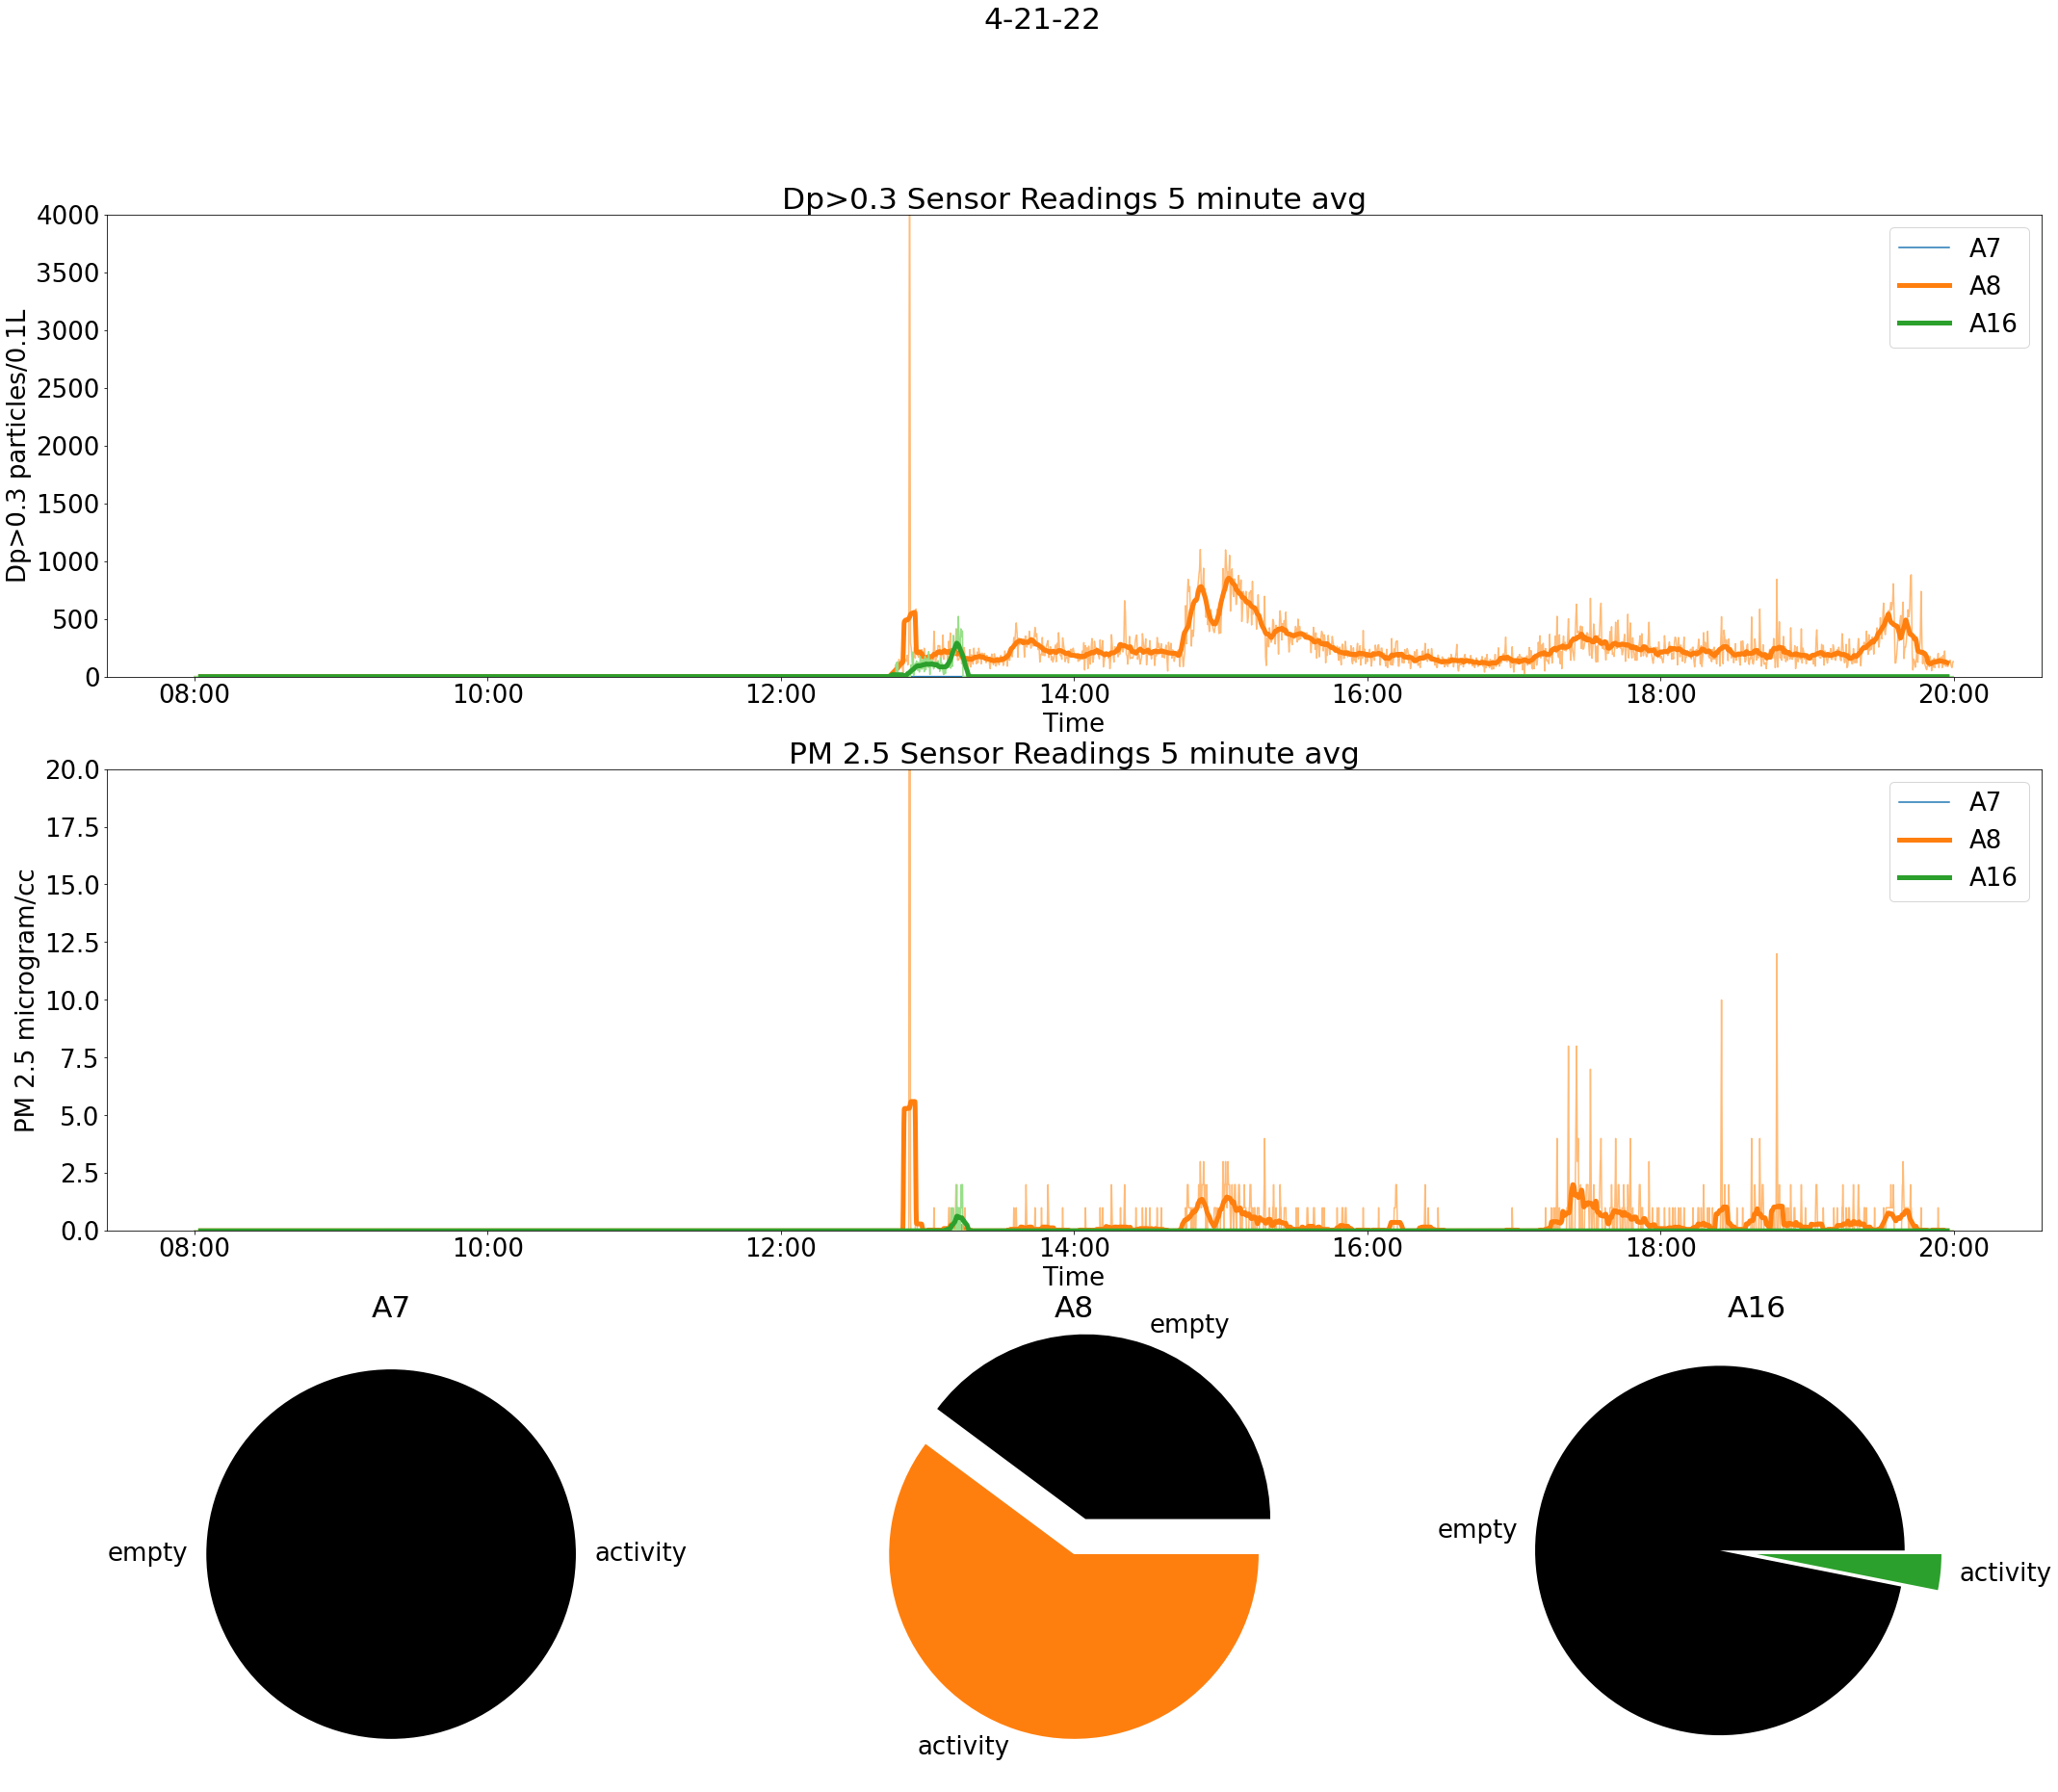

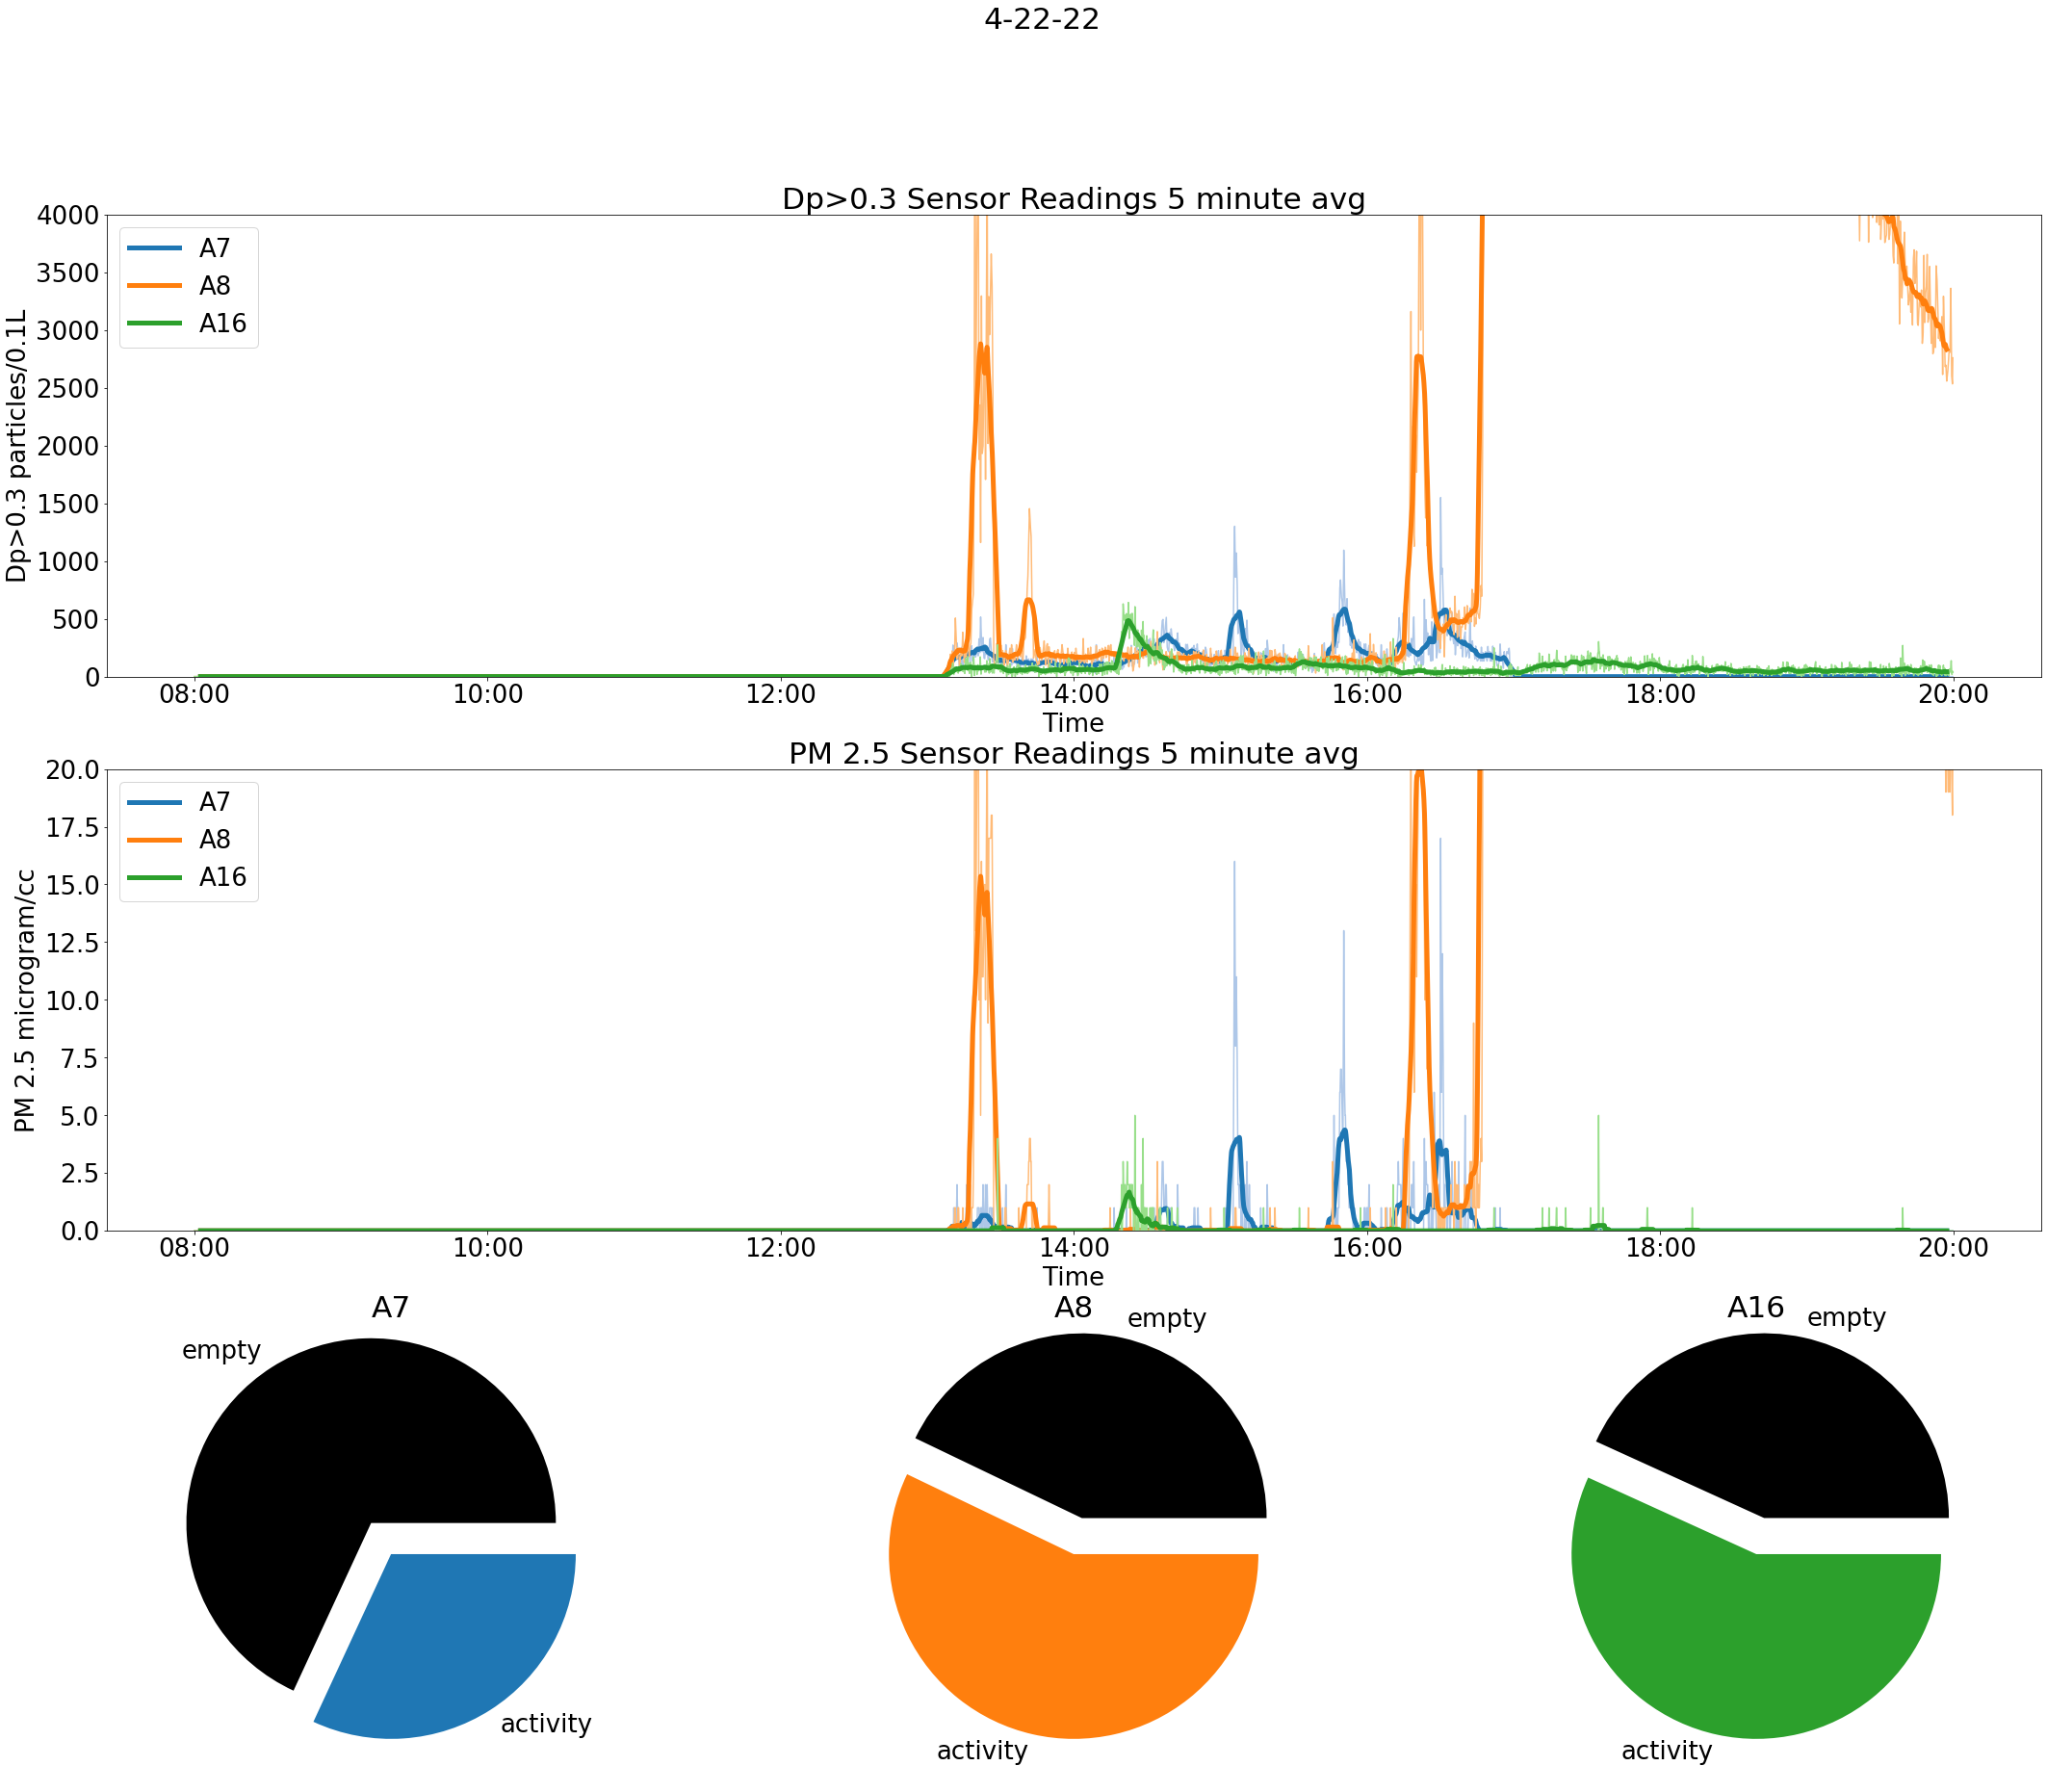

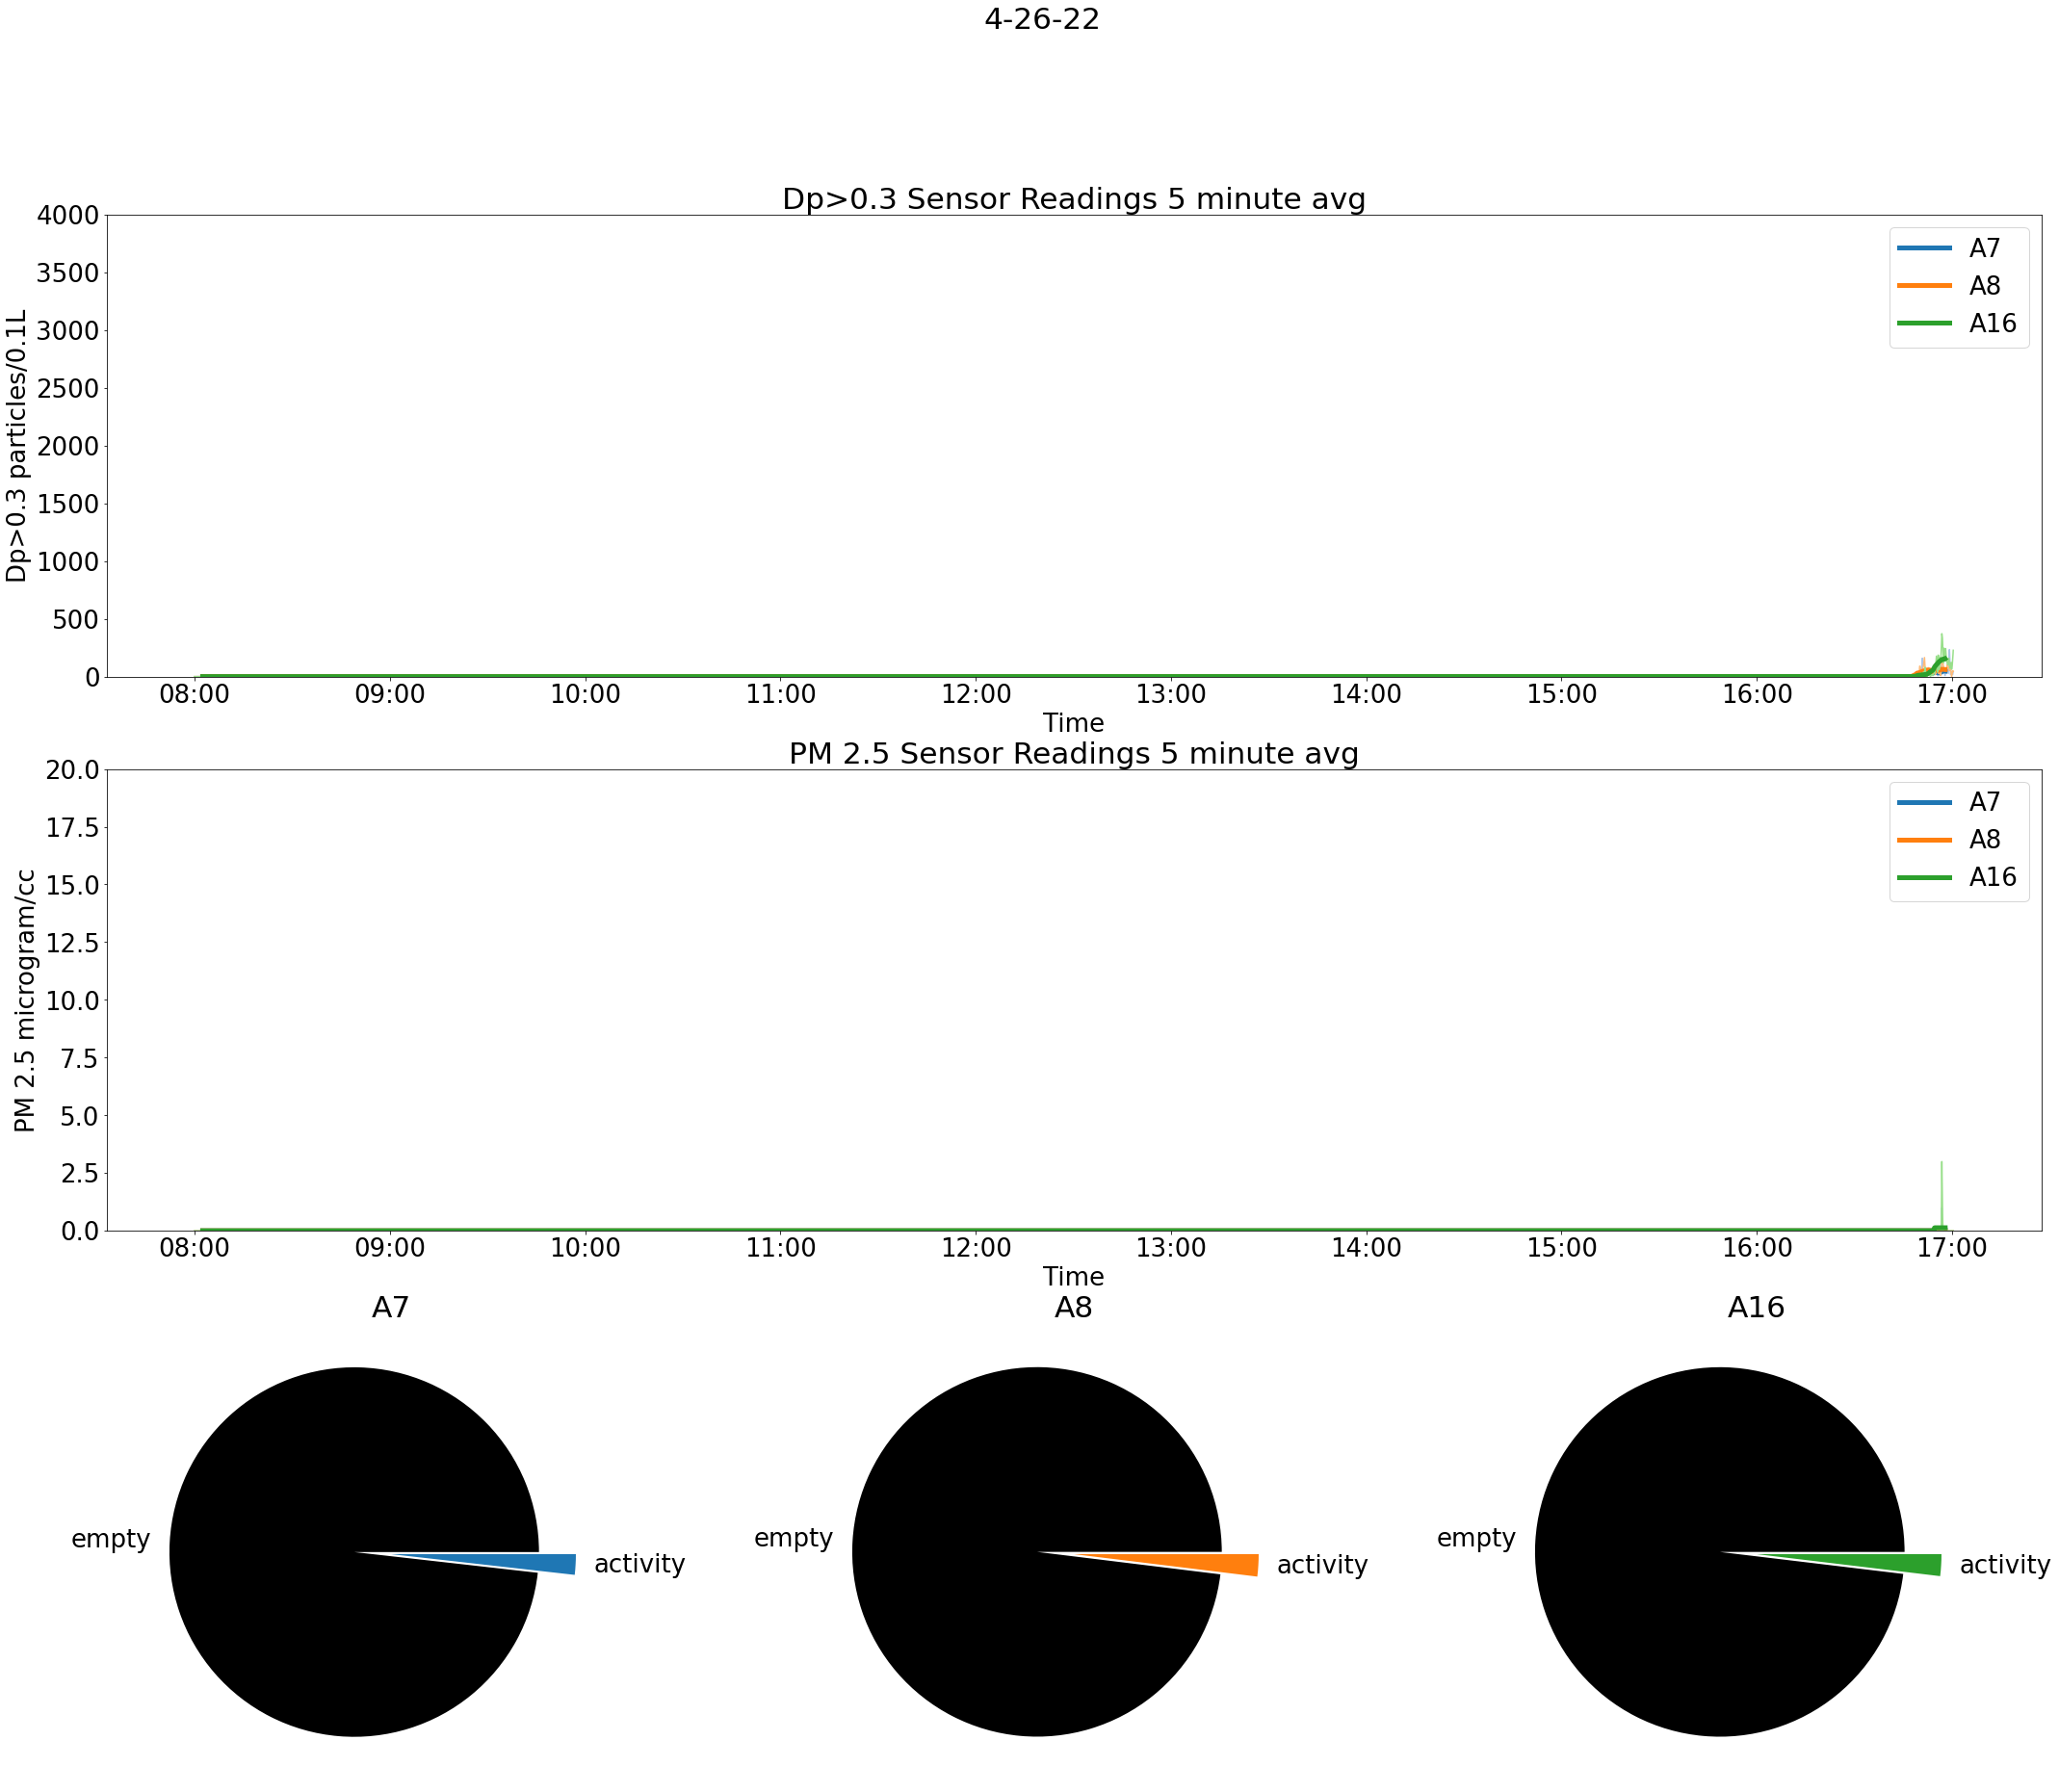

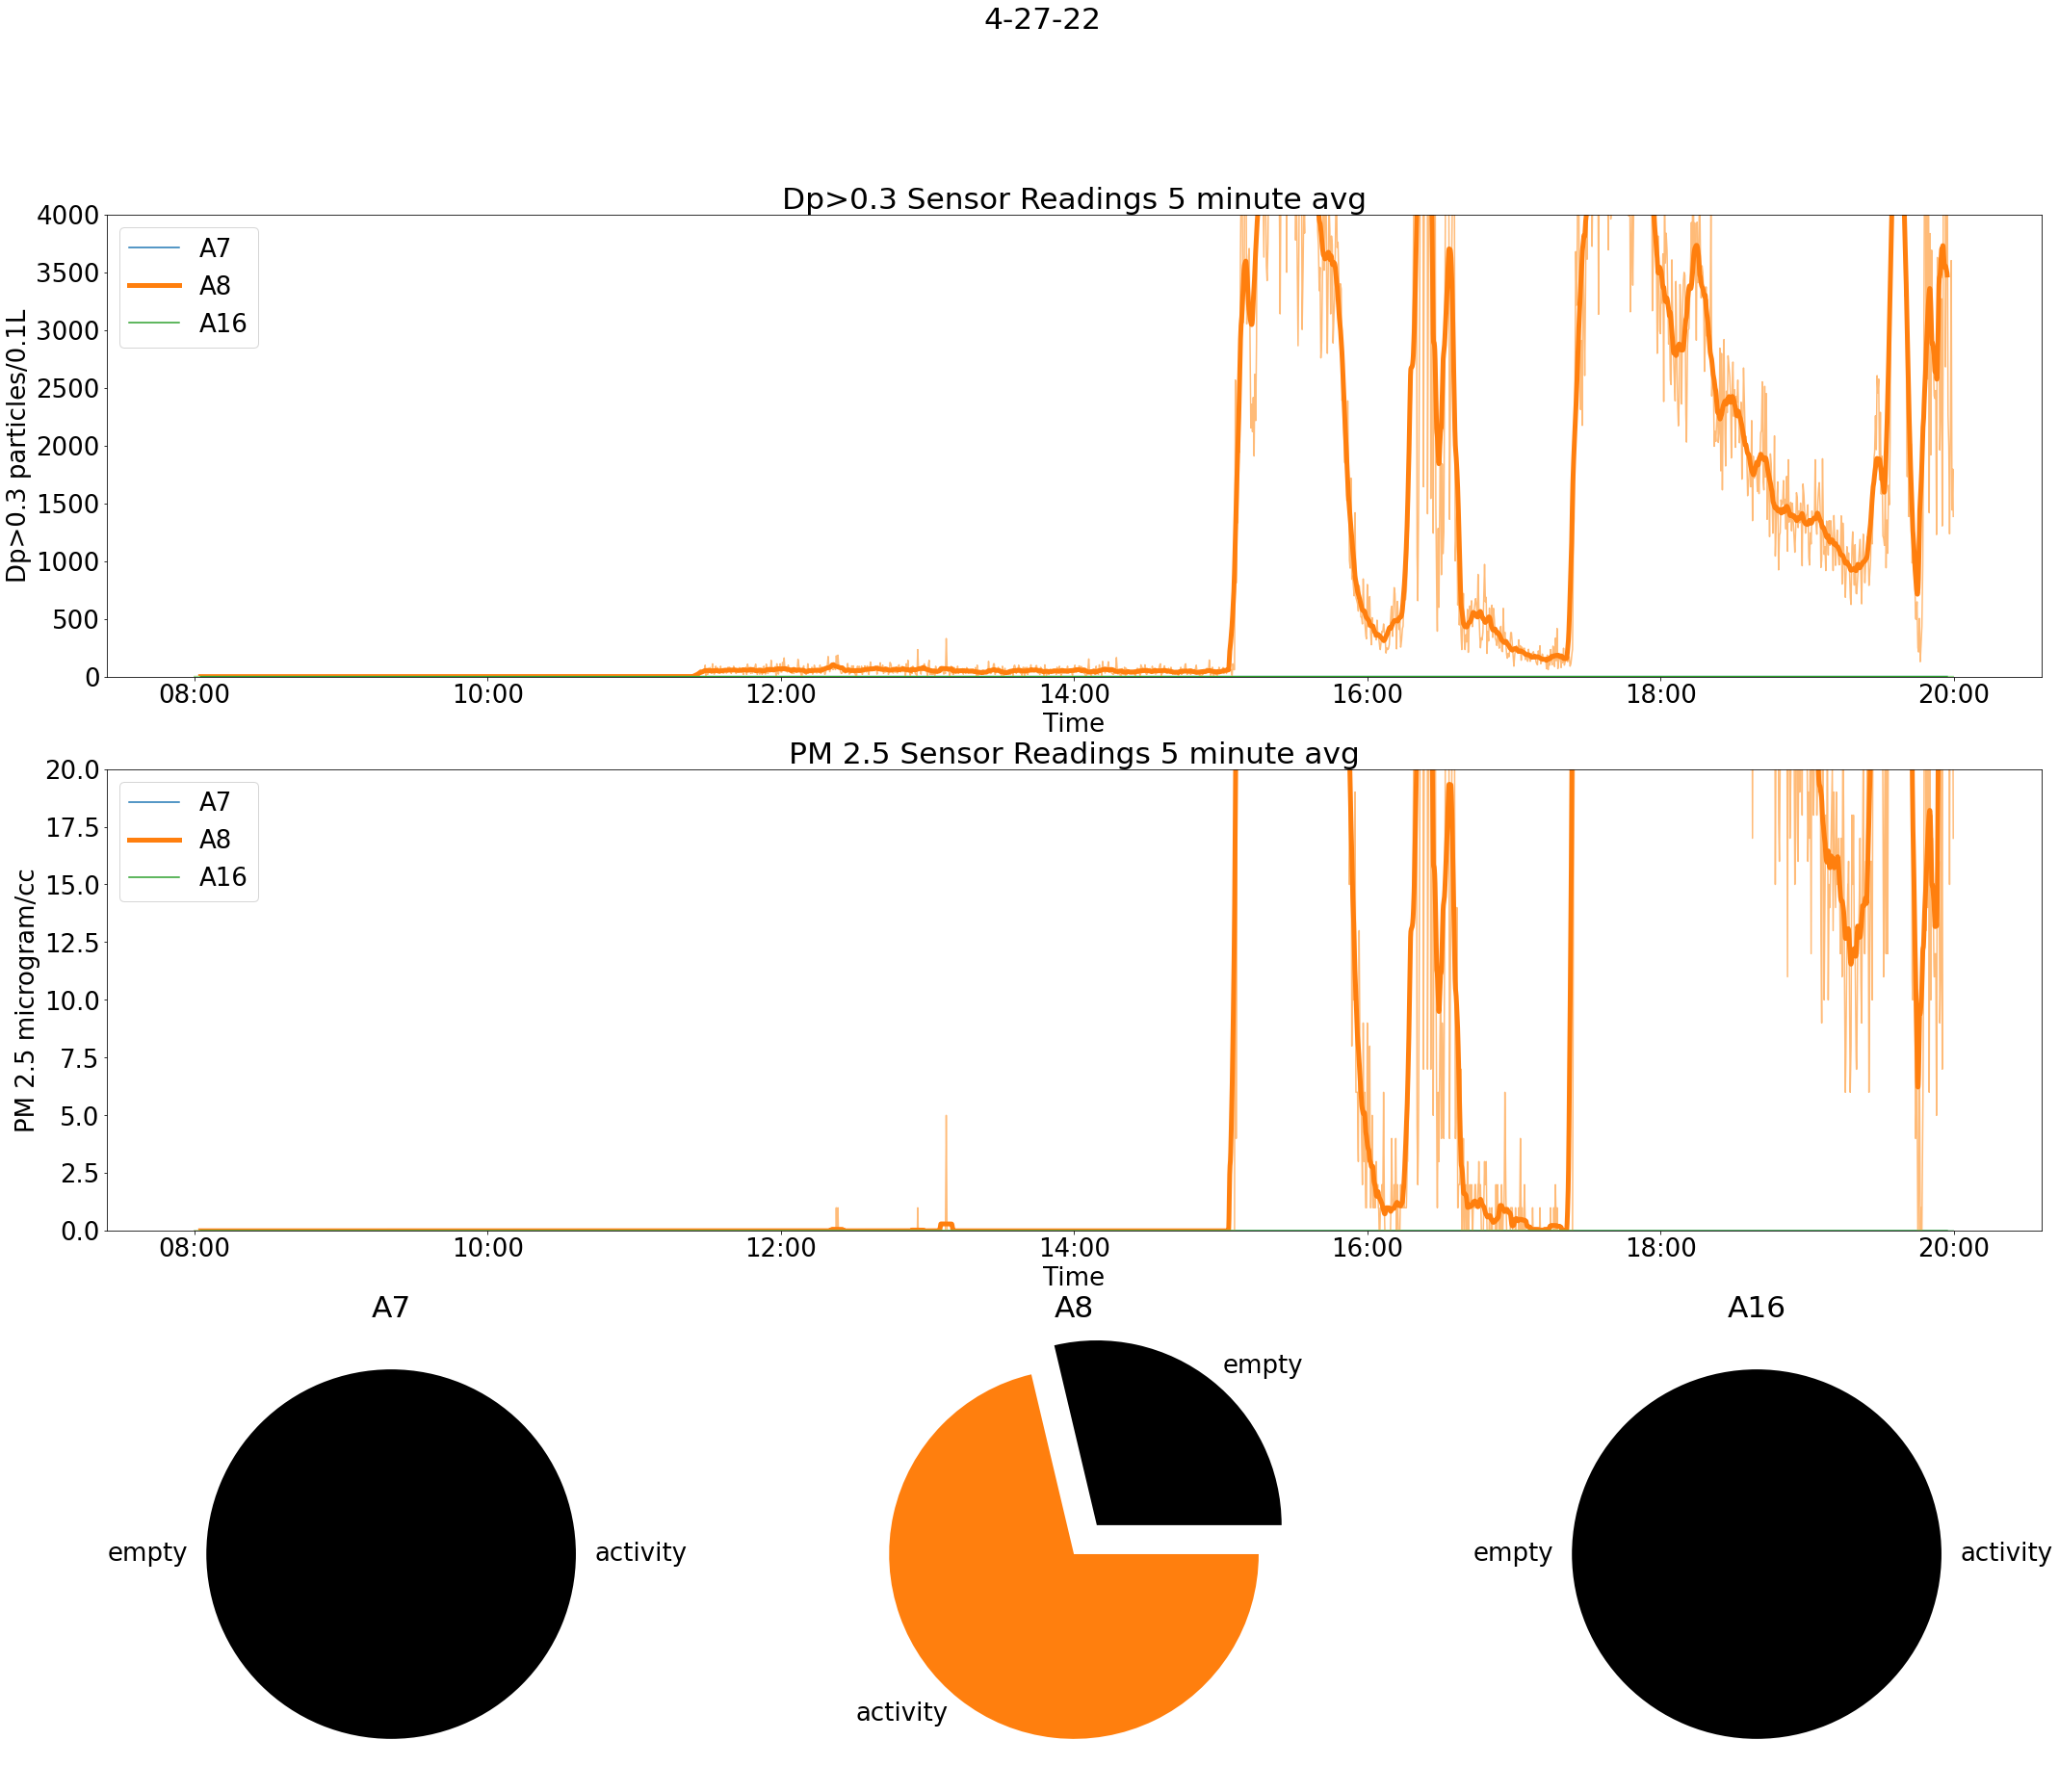

In [135]:
for (pm25name,pm25frame), (dp03name,dp03frame) in zip(mergedDataPM25.items(),mergedDataDp03.items()):
    sensors = ['A7', 'A8', 'A16']
    fig1 = plt.figure(figsize=(36,30))
    ax1= fig1.add_subplot(3,1,1)
    ax11 = fig1.add_subplot(3,1,2)
    ax2= fig1.add_subplot(3,3,7)
    ax3= fig1.add_subplot(3,3,8)
    ax4= fig1.add_subplot(3,3,9)
    ax = [ax1,ax11,ax2,ax3,ax4]
    myFmt = mdates.DateFormatter('%H:%M')
    ax[0].xaxis.set_major_formatter(myFmt)
    ax[1].xaxis.set_major_formatter(myFmt)

    newdp03frame = dp03frame.set_index("Date_Time").rolling(60*5, center = True).mean().dropna()
    dp03frame = dp03frame.set_index("Date_Time")

    newpm25frame = pm25frame.set_index("Date_Time").rolling(60*5, center = True).mean().dropna()
    pm25frame = pm25frame.set_index("Date_Time")

    for i, column in enumerate(sensors):
        try:
            emptyPercent = round(sum([1 if i == 0 else 0 for i in dp03frame[column]])/len(dp03frame[column])*100,2)
            ax[0].plot(dp03frame.index,dp03frame[column],color = color[i*2+1])
            ax[0].plot(newdp03frame.index,newdp03frame[column],color = color[i*2], linewidth = 5,label = f"{column}")
            ax[1].plot(pm25frame.index,pm25frame[column],color = color[i*2+1])
            ax[1].plot(newpm25frame.index,newpm25frame[column],color = color[i*2], linewidth = 5,label = f"{column}")
            ax[i+2].pie([emptyPercent,100-emptyPercent],colors = ["black",color[i*2]],labels = ["empty","activity"], explode = [0.2,0])
            ax[i+2].set(title = column)
        except:
            ax[0].plot(dp03frame.index,[0]*len(dp03frame),'-',color = color[i*2+1])
            ax[0].plot(newdp03frame.index,[0]*len(newdp03frame),'-',color = color[i*2],label = f"{column}")
            ax[1].plot(pm25frame.index,[0]*len(pm25frame),'-',color = color[i*2+1])
            ax[1].plot(newpm25frame.index,[0]*len(newpm25frame),'-',color = color[i*2],label = f"{column}")
            ax[i+2].pie([100,0],colors = ["black",color[i*2]],labels = ["empty","activity"])
            ax[i+2].set(title = column)

    ax[0].legend()
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel('Dp>0.3 particles/0.1L')
    ax[0].set_ylim([0,4000])
    ax[0].set(title= f"Dp>0.3 Sensor Readings 5 minute avg")
    ax[1].legend()
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel('PM 2.5 microgram/cc')
    ax[1].set_ylim([0,20])
    ax[1].set(title= f"PM 2.5 Sensor Readings 5 minute avg")
    plt.suptitle(f"{dp03name.replace('_','-')}")

    imagePath = os.path.join("..","..","Graphs, Images, and Animations")
    if not os.path.exists(imagePath):
        os.mkdir(imagePath)
    plt.savefig(os.path.join(imagePath,f"activity_{dp03name}.jpg"))


# Calculate the "decay frame" 
the decay frame is a frame of the slopes of the rolling average. This takes about 20 seconds per day

In [118]:
def calc_slope(x):
    slope = np.polyfit(range(len(x)), x, 1)[0]
    return slope

In [110]:
decayFrame = {}
for dp03name,dp03frame in mergedDataDp03.items():
    decayFrame[dp03name] = dp03frame.set_index("Date_Time").rolling(10, min_periods=2).apply(calc_slope)[4::5]
decayFrame


{'4-13-22':                           A16   A7   A8   Average   Variance
 Date_Time                                                   
 2022-04-13 10:00:04  0.000000  0.0  0.0  0.000000   0.000000
 2022-04-13 10:00:09  0.000000  0.0  0.0  0.000000   0.000000
 2022-04-13 10:00:14  0.000000  0.0  0.0  0.000000   0.000000
 2022-04-13 10:00:19  0.000000  0.0  0.0  0.000000   0.000000
 2022-04-13 10:00:24  0.000000  0.0  0.0  0.000000   0.000000
 ...                       ...  ...  ...       ...        ...
 2022-04-13 16:59:29 -6.300000  0.0  0.0 -2.100000 -85.050000
 2022-04-13 16:59:34 -2.609091  0.0  0.0 -0.869697 -41.840909
 2022-04-13 16:59:39  2.400000  0.0  0.0  0.800000  16.800000
 2022-04-13 16:59:44  0.872727  0.0  0.0  0.290909   5.090909
 2022-04-13 16:59:49 -1.200000  0.0  0.0 -0.400000 -10.800000
 
 [5038 rows x 5 columns],
 '4-14-22':                           A16        A8   Average    Variance
 Date_Time                                                    
 2022-04-14 10:00:

### All Sensors Plotted

In [ ]:
mergedData

In [ ]:

fig,sPlt=plt.subplots(18,sharex=False,sharey=False,figsize=(20,35))
# fig.delaxes(sPlt[1,1])
DataFrame = mergedData

for idx,sensor in enumerate(DataFrame.columns[1:19]):
    yData = (DataFrame[sensor])
    xData = [i for i in range(-60,len(yData)-60)]

    sPlt[idx].plot(xData,yData,color = color[idx],label = sensor)

    sPlt[idx].plot([60,60], [0,12], "--", lw=0.5, color="black", alpha=0.3)
    sPlt[idx].plot([0,0], [0,12], "--", lw=0.5, color="black", alpha=0.3) 
    sPlt[idx].set(title=sensor,xlabel='Time',ylabel='Measured Particles')



for ax in sPlt:
    ax.spines["top"].set_visible(False)   
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False) 
    # ax.legend(prop={'size':9})
    ax.set_ylim([1,5000])
    # ax.set_yscale("log")

    
    
plt.tight_layout()
plt.rcParams.update({'font.size':16})
mpld3.save_html(fig,'IndSensors.html')
